In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import time

t0 = time.time()

In [1]:
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
import json
import scipy.stats as stats
from matplotlib.patches import Ellipse
from aml_dl.mdn.model.mdn_push_fwd_model import MDNPushFwdModel
import tf.transformations as tfm


In [6]:
sess = tf.InteractiveSession()
    
adam_params = {
    'type': 'adam',
    'params': {'learning_rate' : 0.0001, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08, 'use_locking': False}
}

network_params = {
    'dim_input': 8, 
    'dim_output': 3,
    'n_hidden': 400,
    'k_mixtures': 200,
    'write_summary': False,
    'learning_rate': 0.00005,
    'load_saved_model': False,
    'optimiser': adam_params,
    'device': '/cpu:0',
    'dropout_prob': 0.8,
    'weight_multiplier': 1.0, # changed iteratively later on only if halfweightValidation used (for dropout)
    'weight_reg_coef': 0.001, # change to factor weight size regularization
    'max_weight_mag': 1000, # set high to turn off weight contraining
}

forward_model = MDNPushFwdModel(sess=sess, network_params=network_params)
forward_model.init_model()

In [9]:
a = np.array([[1,2,3,4],[5,6,7,8]])
print(np.shape(a))
print(np.mean(a,0))

(2, 4)
[3. 4. 5. 6.]


In [7]:
# load data
json_filepath = '/home/harry/Honeycomb/surface_compare/delrin/rect1_json/data_training_with_shapeBounds_andForce.json'

with open(json_filepath) as data_file:    
		data_rect1 = json.load(data_file)

In [8]:
# steps needed for the shapes dataset, remove once optimized for any data
shape_ids = ['rect1']
#----------------------CHANGE FOR DIFFERENT VAL SET---------------------------------        
train_data = []
train_data.extend(data_rect1)

print len(train_data), "=len(train_data) with all velos"

# removes all velocity cases
dataNew = []
for i in range(len(train_data)):
    if (train_data[i][13] == 10):
        dataNew.append(train_data[i])
train_data = np.array(dataNew)
#train_data = dataNew

np.random.shuffle(train_data)
val_data = train_data[0:int(len(train_data)*0.10)]
train_data = train_data[int(len(train_data)*0.10):len(train_data)]

print len(train_data), "=len(train_data) with no velos"
print len(val_data), "=len(val_data) with no velos"

3960 =len(train_data) with all velos
357 =len(train_data) with no velos
39 =len(val_data) with no velos


In [9]:
#all_data = np.vstack((train_data, val_data))

train_data = train_data[:, np.r_[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]] # inputs
val_data =     val_data[:, np.r_[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]] # inputs

all_data = np.vstack((train_data, val_data))
mins = np.amin(all_data, axis = 0)
maxs = np.amax(all_data, axis = 0)
train_data = (train_data-mins)/(maxs-mins)
val_data = (val_data-mins)/(maxs-mins)

dataX =   train_data[:, np.r_[0, 1, 2, 3, 4, 5, 6, 10]] # inputs
dataY =   train_data[:, [7,8, 9]] # end parameters

dataX_val = val_data[:, np.r_[0, 1, 2, 3, 4, 5, 6, 10]] # inputs
dataY_val = val_data[:, [7,8, 9]] # end parameters

np.shape(dataX)

(357, 8)

In [10]:
Ymins = np.r_[mins[7:10]] # 7,8,9
Ymaxs = np.r_[maxs[7:10]]
Xmins = np.r_[mins[0:7], mins[10:13], mins[14:65]] # 1,2,3,4,5,6,10,11,12,14
Xmaxs = np.r_[maxs[0:7], maxs[10:13], maxs[14:65]]

In [11]:
#all_data = np.vstack((train_data, val_data))
# rescale (standardised variance, mean 0)

#means = np.mean(all_data, axis = 0).reshape(1,len(all_data[1])) # vector length shape(1,d)
#mean_translations = all_data - np.dot(np.ones((len(all_data),1)), means) # array size shape(M,d)
#variances = np.mean(mean_translations**2, axis = 0).reshape(1,len(all_data[1])) # vector length shape(1,d)

#train_data = np.divide((train_data - np.dot(np.ones((len(train_data),1)), means)),variances)
#dataX = train_data[:, np.r_[0, 1, 2, 3, 4, 5, 6, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]] # inputs
#dataY = train_data[:, [7,8, 9]] # end parameters

#val_data = np.divide((val_data - np.dot(np.ones((len(val_data),1)), means)), variances)
#dataX_val = val_data[:, np.r_[0, 1, 2, 3, 4, 5, 6, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]] # inputs
#dataY_val = val_data[:, [7,8, 9]] # end parameters

In [12]:
print(np.shape(dataX))

(357, 8)


In [13]:
print(np.shape(dataY))

(357, 3)


In [ ]:
plt.scatter(train_data[:,27], train_data[:,34])

Starting epoch 	0
Starting epoch 	1
Starting epoch 	2
Starting epoch 	3
Starting epoch 	4
Starting epoch 	5
Starting epoch 	6
Starting epoch 	7
Starting epoch 	8
Starting epoch 	9
Starting epoch 	10
Starting epoch 	11
Starting epoch 	12
Starting epoch 	13
Starting epoch 	14
Starting epoch 	15
Starting epoch 	16
Starting epoch 	17
Starting epoch 	18
Starting epoch 	19
Starting epoch 	20
Starting epoch 	21
Starting epoch 	22
Starting epoch 	23
Starting epoch 	24
Starting epoch 	25
Starting epoch 	26
Starting epoch 	27
Starting epoch 	28
Starting epoch 	29
Starting epoch 	30
Starting epoch 	31
Starting epoch 	32
Starting epoch 	33
Starting epoch 	34
Starting epoch 	35
Starting epoch 	36
Starting epoch 	37
Starting epoch 	38
Starting epoch 	39
Starting epoch 	40
Starting epoch 	41
Starting epoch 	42
Starting epoch 	43
Starting epoch 	44
Starting epoch 	45
Starting epoch 	46
Starting epoch 	47
Starting epoch 	48
Starting epoch 	49
Starting epoch 	50
Starting epoch 	51
Starting epoch 	52
Sta

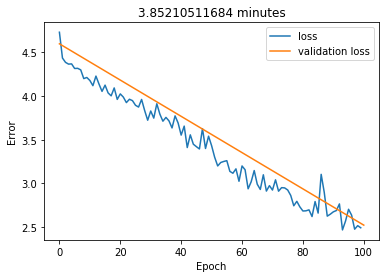

Starting epoch 	101
Starting epoch 	102
Starting epoch 	103
Starting epoch 	104
Starting epoch 	105
Starting epoch 	106
Starting epoch 	107
Starting epoch 	108
Starting epoch 	109
Starting epoch 	110
Starting epoch 	111
Starting epoch 	112
Starting epoch 	113
Starting epoch 	114
Starting epoch 	115
Starting epoch 	116
Starting epoch 	117
Starting epoch 	118
Starting epoch 	119
Starting epoch 	120
Starting epoch 	121
Starting epoch 	122
Starting epoch 	123
Starting epoch 	124
Starting epoch 	125
Starting epoch 	126
Starting epoch 	127
Starting epoch 	128
Starting epoch 	129
Starting epoch 	130
Starting epoch 	131
Starting epoch 	132
Starting epoch 	133
Starting epoch 	134
Starting epoch 	135
Starting epoch 	136
Starting epoch 	137
Starting epoch 	138
Starting epoch 	139
Starting epoch 	140
Starting epoch 	141
Starting epoch 	142
Starting epoch 	143
Starting epoch 	144
Starting epoch 	145
Starting epoch 	146
Starting epoch 	147
Starting epoch 	148
Starting epoch 	149
Starting epoch 	150


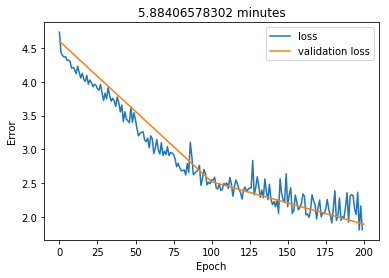

Starting epoch 	201
Starting epoch 	202
Starting epoch 	203
Starting epoch 	204
Starting epoch 	205
Starting epoch 	206
Starting epoch 	207
Starting epoch 	208
Starting epoch 	209
Starting epoch 	210
Starting epoch 	211
Starting epoch 	212
Starting epoch 	213
Starting epoch 	214
Starting epoch 	215
Starting epoch 	216
Starting epoch 	217
Starting epoch 	218
Starting epoch 	219
Starting epoch 	220
Starting epoch 	221
Starting epoch 	222
Starting epoch 	223
Starting epoch 	224
Starting epoch 	225
Starting epoch 	226
Starting epoch 	227
Starting epoch 	228
Starting epoch 	229
Starting epoch 	230
Starting epoch 	231
Starting epoch 	232
Starting epoch 	233
Starting epoch 	234
Starting epoch 	235
Starting epoch 	236
Starting epoch 	237
Starting epoch 	238
Starting epoch 	239
Starting epoch 	240
Starting epoch 	241
Starting epoch 	242
Starting epoch 	243
Starting epoch 	244
Starting epoch 	245
Starting epoch 	246
Starting epoch 	247
Starting epoch 	248
Starting epoch 	249
Starting epoch 	250


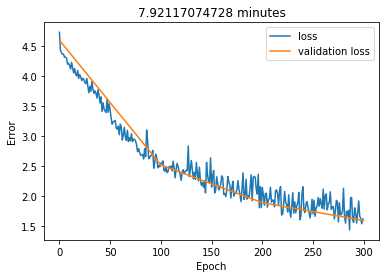

Starting epoch 	301
Starting epoch 	302
Starting epoch 	303
Starting epoch 	304
Starting epoch 	305
Starting epoch 	306
Starting epoch 	307
Starting epoch 	308
Starting epoch 	309
Starting epoch 	310
Starting epoch 	311
Starting epoch 	312
Starting epoch 	313
Starting epoch 	314
Starting epoch 	315
Starting epoch 	316
Starting epoch 	317
Starting epoch 	318
Starting epoch 	319
Starting epoch 	320
Starting epoch 	321
Starting epoch 	322
Starting epoch 	323
Starting epoch 	324
Starting epoch 	325
Starting epoch 	326
Starting epoch 	327
Starting epoch 	328
Starting epoch 	329
Starting epoch 	330
Starting epoch 	331
Starting epoch 	332
Starting epoch 	333
Starting epoch 	334
Starting epoch 	335
Starting epoch 	336
Starting epoch 	337
Starting epoch 	338
Starting epoch 	339
Starting epoch 	340
Starting epoch 	341
Starting epoch 	342
Starting epoch 	343
Starting epoch 	344
Starting epoch 	345
Starting epoch 	346
Starting epoch 	347
Starting epoch 	348
Starting epoch 	349
Starting epoch 	350


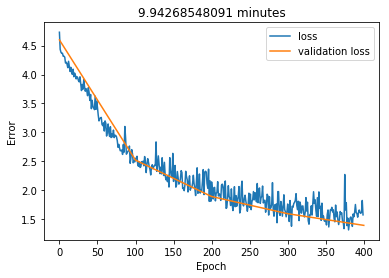

Starting epoch 	401
Starting epoch 	402
Starting epoch 	403
Starting epoch 	404
Starting epoch 	405
Starting epoch 	406
Starting epoch 	407
Starting epoch 	408
Starting epoch 	409
Starting epoch 	410
Starting epoch 	411
Starting epoch 	412
Starting epoch 	413
Starting epoch 	414
Starting epoch 	415
Starting epoch 	416
Starting epoch 	417
Starting epoch 	418
Starting epoch 	419
Starting epoch 	420
Starting epoch 	421
Starting epoch 	422
Starting epoch 	423
Starting epoch 	424
Starting epoch 	425
Starting epoch 	426
Starting epoch 	427
Starting epoch 	428
Starting epoch 	429
Starting epoch 	430
Starting epoch 	431
Starting epoch 	432
Starting epoch 	433
Starting epoch 	434
Starting epoch 	435
Starting epoch 	436
Starting epoch 	437
Starting epoch 	438
Starting epoch 	439
Starting epoch 	440
Starting epoch 	441
Starting epoch 	442
Starting epoch 	443
Starting epoch 	444
Starting epoch 	445
Starting epoch 	446
Starting epoch 	447
Starting epoch 	448
Starting epoch 	449
Starting epoch 	450


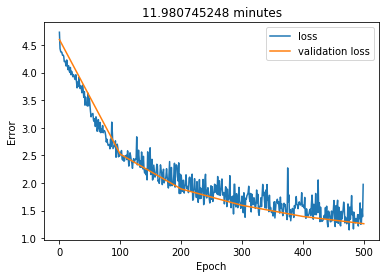

Starting epoch 	501
Starting epoch 	502
Starting epoch 	503
Starting epoch 	504
Starting epoch 	505
Starting epoch 	506
Starting epoch 	507
Starting epoch 	508
Starting epoch 	509
Starting epoch 	510
Starting epoch 	511
Starting epoch 	512
Starting epoch 	513
Starting epoch 	514
Starting epoch 	515
Starting epoch 	516
Starting epoch 	517
Starting epoch 	518
Starting epoch 	519
Starting epoch 	520
Starting epoch 	521
Starting epoch 	522
Starting epoch 	523
Starting epoch 	524
Starting epoch 	525
Starting epoch 	526
Starting epoch 	527
Starting epoch 	528
Starting epoch 	529
Starting epoch 	530
Starting epoch 	531
Starting epoch 	532
Starting epoch 	533
Starting epoch 	534
Starting epoch 	535
Starting epoch 	536
Starting epoch 	537
Starting epoch 	538
Starting epoch 	539
Starting epoch 	540
Starting epoch 	541
Starting epoch 	542
Starting epoch 	543
Starting epoch 	544
Starting epoch 	545
Starting epoch 	546
Starting epoch 	547
Starting epoch 	548
Starting epoch 	549
Starting epoch 	550


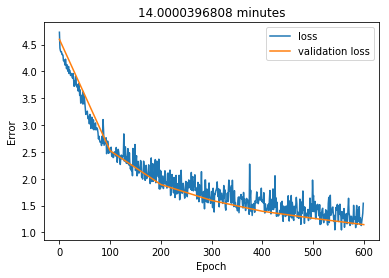

Starting epoch 	601
Starting epoch 	602
Starting epoch 	603
Starting epoch 	604
Starting epoch 	605
Starting epoch 	606
Starting epoch 	607
Starting epoch 	608
Starting epoch 	609
Starting epoch 	610
Starting epoch 	611
Starting epoch 	612
Starting epoch 	613
Starting epoch 	614
Starting epoch 	615
Starting epoch 	616
Starting epoch 	617
Starting epoch 	618
Starting epoch 	619
Starting epoch 	620
Starting epoch 	621
Starting epoch 	622
Starting epoch 	623
Starting epoch 	624
Starting epoch 	625
Starting epoch 	626
Starting epoch 	627
Starting epoch 	628
Starting epoch 	629
Starting epoch 	630
Starting epoch 	631
Starting epoch 	632
Starting epoch 	633
Starting epoch 	634
Starting epoch 	635
Starting epoch 	636
Starting epoch 	637
Starting epoch 	638
Starting epoch 	639
Starting epoch 	640
Starting epoch 	641
Starting epoch 	642
Starting epoch 	643
Starting epoch 	644
Starting epoch 	645
Starting epoch 	646
Starting epoch 	647
Starting epoch 	648
Starting epoch 	649
Starting epoch 	650


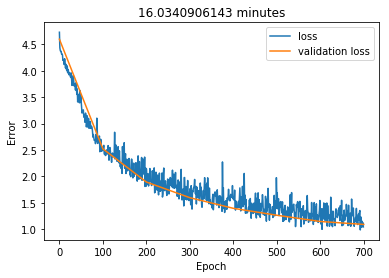

Starting epoch 	701
Starting epoch 	702
Starting epoch 	703
Starting epoch 	704
Starting epoch 	705
Starting epoch 	706
Starting epoch 	707
Starting epoch 	708
Starting epoch 	709
Starting epoch 	710
Starting epoch 	711
Starting epoch 	712
Starting epoch 	713
Starting epoch 	714
Starting epoch 	715
Starting epoch 	716
Starting epoch 	717
Starting epoch 	718
Starting epoch 	719
Starting epoch 	720
Starting epoch 	721
Starting epoch 	722
Starting epoch 	723
Starting epoch 	724
Starting epoch 	725
Starting epoch 	726
Starting epoch 	727
Starting epoch 	728
Starting epoch 	729
Starting epoch 	730
Starting epoch 	731
Starting epoch 	732
Starting epoch 	733
Starting epoch 	734
Starting epoch 	735
Starting epoch 	736
Starting epoch 	737
Starting epoch 	738
Starting epoch 	739
Starting epoch 	740
Starting epoch 	741
Starting epoch 	742
Starting epoch 	743
Starting epoch 	744
Starting epoch 	745
Starting epoch 	746
Starting epoch 	747
Starting epoch 	748
Starting epoch 	749
Starting epoch 	750


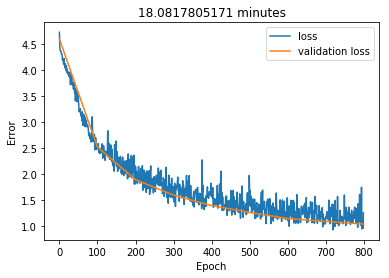

Starting epoch 	801
Starting epoch 	802
Starting epoch 	803
Starting epoch 	804
Starting epoch 	805
Starting epoch 	806
Starting epoch 	807
Starting epoch 	808
Starting epoch 	809
Starting epoch 	810
Starting epoch 	811
Starting epoch 	812
Starting epoch 	813
Starting epoch 	814
Starting epoch 	815
Starting epoch 	816
Starting epoch 	817
Starting epoch 	818
Starting epoch 	819
Starting epoch 	820
Starting epoch 	821
Starting epoch 	822
Starting epoch 	823
Starting epoch 	824
Starting epoch 	825
Starting epoch 	826
Starting epoch 	827
Starting epoch 	828
Starting epoch 	829
Starting epoch 	830
Starting epoch 	831
Starting epoch 	832
Starting epoch 	833
Starting epoch 	834
Starting epoch 	835
Starting epoch 	836
Starting epoch 	837
Starting epoch 	838
Starting epoch 	839
Starting epoch 	840
Starting epoch 	841
Starting epoch 	842
Starting epoch 	843
Starting epoch 	844
Starting epoch 	845
Starting epoch 	846
Starting epoch 	847
Starting epoch 	848
Starting epoch 	849
Starting epoch 	850


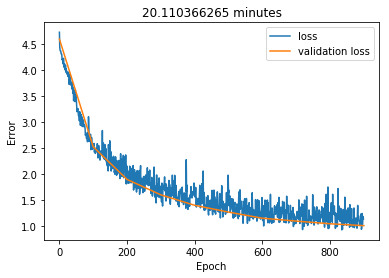

Starting epoch 	901
Starting epoch 	902
Starting epoch 	903
Starting epoch 	904
Starting epoch 	905
Starting epoch 	906
Starting epoch 	907
Starting epoch 	908
Starting epoch 	909
Starting epoch 	910
Starting epoch 	911
Starting epoch 	912
Starting epoch 	913
Starting epoch 	914
Starting epoch 	915
Starting epoch 	916
Starting epoch 	917
Starting epoch 	918
Starting epoch 	919
Starting epoch 	920
Starting epoch 	921
Starting epoch 	922
Starting epoch 	923
Starting epoch 	924
Starting epoch 	925
Starting epoch 	926
Starting epoch 	927
Starting epoch 	928
Starting epoch 	929
Starting epoch 	930
Starting epoch 	931
Starting epoch 	932
Starting epoch 	933
Starting epoch 	934
Starting epoch 	935
Starting epoch 	936
Starting epoch 	937
Starting epoch 	938
Starting epoch 	939
Starting epoch 	940
Starting epoch 	941
Starting epoch 	942
Starting epoch 	943
Starting epoch 	944
Starting epoch 	945
Starting epoch 	946
Starting epoch 	947
Starting epoch 	948
Starting epoch 	949
Starting epoch 	950


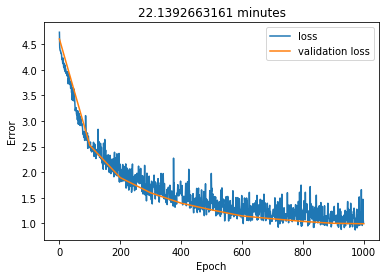

Starting epoch 	1001
Starting epoch 	1002
Starting epoch 	1003
Starting epoch 	1004
Starting epoch 	1005
Starting epoch 	1006
Starting epoch 	1007
Starting epoch 	1008
Starting epoch 	1009
Starting epoch 	1010
Starting epoch 	1011
Starting epoch 	1012
Starting epoch 	1013
Starting epoch 	1014
Starting epoch 	1015
Starting epoch 	1016
Starting epoch 	1017
Starting epoch 	1018
Starting epoch 	1019
Starting epoch 	1020
Starting epoch 	1021
Starting epoch 	1022
Starting epoch 	1023
Starting epoch 	1024
Starting epoch 	1025
Starting epoch 	1026
Starting epoch 	1027
Starting epoch 	1028
Starting epoch 	1029
Starting epoch 	1030
Starting epoch 	1031
Starting epoch 	1032
Starting epoch 	1033
Starting epoch 	1034
Starting epoch 	1035
Starting epoch 	1036
Starting epoch 	1037
Starting epoch 	1038
Starting epoch 	1039
Starting epoch 	1040
Starting epoch 	1041
Starting epoch 	1042
Starting epoch 	1043
Starting epoch 	1044
Starting epoch 	1045
Starting epoch 	1046
Starting epoch 	1047
Starting epoc

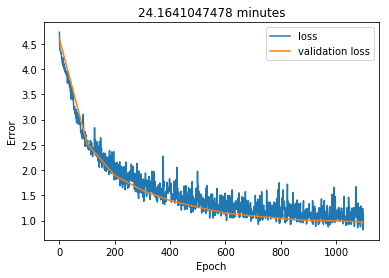

Starting epoch 	1101
Starting epoch 	1102
Starting epoch 	1103
Starting epoch 	1104
Starting epoch 	1105
Starting epoch 	1106
Starting epoch 	1107
Starting epoch 	1108
Starting epoch 	1109
Starting epoch 	1110
Starting epoch 	1111
Starting epoch 	1112
Starting epoch 	1113
Starting epoch 	1114
Starting epoch 	1115
Starting epoch 	1116
Starting epoch 	1117
Starting epoch 	1118
Starting epoch 	1119
Starting epoch 	1120
Starting epoch 	1121
Starting epoch 	1122
Starting epoch 	1123
Starting epoch 	1124
Starting epoch 	1125
Starting epoch 	1126
Starting epoch 	1127
Starting epoch 	1128
Starting epoch 	1129
Starting epoch 	1130
Starting epoch 	1131
Starting epoch 	1132
Starting epoch 	1133
Starting epoch 	1134
Starting epoch 	1135
Starting epoch 	1136
Starting epoch 	1137
Starting epoch 	1138
Starting epoch 	1139
Starting epoch 	1140
Starting epoch 	1141
Starting epoch 	1142
Starting epoch 	1143
Starting epoch 	1144
Starting epoch 	1145
Starting epoch 	1146
Starting epoch 	1147
Starting epoc

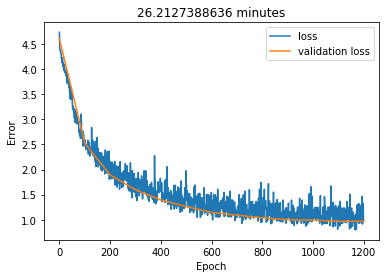

Starting epoch 	1201
Starting epoch 	1202
Starting epoch 	1203
Starting epoch 	1204
Starting epoch 	1205
Starting epoch 	1206
Starting epoch 	1207
Starting epoch 	1208
Starting epoch 	1209
Starting epoch 	1210
Starting epoch 	1211
Starting epoch 	1212
Starting epoch 	1213
Starting epoch 	1214
Starting epoch 	1215
Starting epoch 	1216
Starting epoch 	1217
Starting epoch 	1218
Starting epoch 	1219
Starting epoch 	1220
Starting epoch 	1221
Starting epoch 	1222
Starting epoch 	1223
Starting epoch 	1224
Starting epoch 	1225
Starting epoch 	1226
Starting epoch 	1227
Starting epoch 	1228
Starting epoch 	1229
Starting epoch 	1230
Starting epoch 	1231
Starting epoch 	1232
Starting epoch 	1233
Starting epoch 	1234
Starting epoch 	1235
Starting epoch 	1236
Starting epoch 	1237
Starting epoch 	1238
Starting epoch 	1239
Starting epoch 	1240
Starting epoch 	1241
Starting epoch 	1242
Starting epoch 	1243
Starting epoch 	1244
Starting epoch 	1245
Starting epoch 	1246
Starting epoch 	1247
Starting epoc

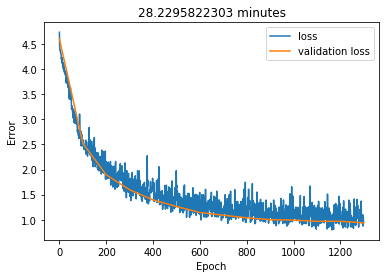

Starting epoch 	1301
Starting epoch 	1302
Starting epoch 	1303
Starting epoch 	1304
Starting epoch 	1305
Starting epoch 	1306
Starting epoch 	1307
Starting epoch 	1308
Starting epoch 	1309
Starting epoch 	1310
Starting epoch 	1311
Starting epoch 	1312
Starting epoch 	1313
Starting epoch 	1314
Starting epoch 	1315
Starting epoch 	1316
Starting epoch 	1317
Starting epoch 	1318
Starting epoch 	1319
Starting epoch 	1320
Starting epoch 	1321
Starting epoch 	1322
Starting epoch 	1323
Starting epoch 	1324
Starting epoch 	1325
Starting epoch 	1326
Starting epoch 	1327
Starting epoch 	1328
Starting epoch 	1329
Starting epoch 	1330
Starting epoch 	1331
Starting epoch 	1332
Starting epoch 	1333
Starting epoch 	1334
Starting epoch 	1335
Starting epoch 	1336
Starting epoch 	1337
Starting epoch 	1338
Starting epoch 	1339
Starting epoch 	1340
Starting epoch 	1341
Starting epoch 	1342
Starting epoch 	1343
Starting epoch 	1344
Starting epoch 	1345
Starting epoch 	1346
Starting epoch 	1347
Starting epoc

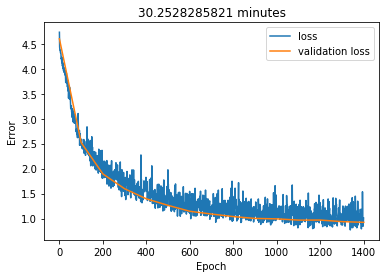

Starting epoch 	1401
Starting epoch 	1402
Starting epoch 	1403
Starting epoch 	1404
Starting epoch 	1405
Starting epoch 	1406
Starting epoch 	1407
Starting epoch 	1408
Starting epoch 	1409
Starting epoch 	1410
Starting epoch 	1411
Starting epoch 	1412
Starting epoch 	1413
Starting epoch 	1414
Starting epoch 	1415
Starting epoch 	1416
Starting epoch 	1417
Starting epoch 	1418
Starting epoch 	1419
Starting epoch 	1420
Starting epoch 	1421
Starting epoch 	1422
Starting epoch 	1423
Starting epoch 	1424
Starting epoch 	1425
Starting epoch 	1426
Starting epoch 	1427
Starting epoch 	1428
Starting epoch 	1429
Starting epoch 	1430
Starting epoch 	1431
Starting epoch 	1432
Starting epoch 	1433
Starting epoch 	1434
Starting epoch 	1435
Starting epoch 	1436
Starting epoch 	1437
Starting epoch 	1438
Starting epoch 	1439
Starting epoch 	1440
Starting epoch 	1441
Starting epoch 	1442
Starting epoch 	1443
Starting epoch 	1444
Starting epoch 	1445
Starting epoch 	1446
Starting epoch 	1447
Starting epoc

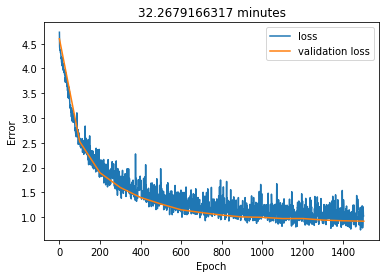

Starting epoch 	1501
Starting epoch 	1502
Starting epoch 	1503
Starting epoch 	1504
Starting epoch 	1505
Starting epoch 	1506
Starting epoch 	1507
Starting epoch 	1508
Starting epoch 	1509
Starting epoch 	1510
Starting epoch 	1511
Starting epoch 	1512
Starting epoch 	1513
Starting epoch 	1514
Starting epoch 	1515
Starting epoch 	1516
Starting epoch 	1517
Starting epoch 	1518
Starting epoch 	1519
Starting epoch 	1520
Starting epoch 	1521
Starting epoch 	1522
Starting epoch 	1523
Starting epoch 	1524
Starting epoch 	1525
Starting epoch 	1526
Starting epoch 	1527
Starting epoch 	1528
Starting epoch 	1529
Starting epoch 	1530
Starting epoch 	1531
Starting epoch 	1532
Starting epoch 	1533
Starting epoch 	1534
Starting epoch 	1535
Starting epoch 	1536
Starting epoch 	1537
Starting epoch 	1538
Starting epoch 	1539
Starting epoch 	1540
Starting epoch 	1541
Starting epoch 	1542
Starting epoch 	1543
Starting epoch 	1544
Starting epoch 	1545
Starting epoch 	1546
Starting epoch 	1547
Starting epoc

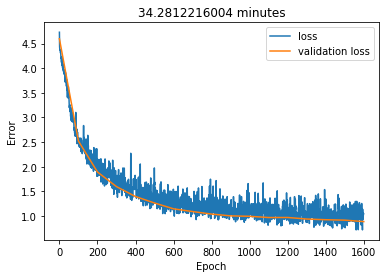

Starting epoch 	1601
Starting epoch 	1602
Starting epoch 	1603
Starting epoch 	1604
Starting epoch 	1605
Starting epoch 	1606
Starting epoch 	1607
Starting epoch 	1608
Starting epoch 	1609
Starting epoch 	1610
Starting epoch 	1611
Starting epoch 	1612
Starting epoch 	1613
Starting epoch 	1614
Starting epoch 	1615
Starting epoch 	1616
Starting epoch 	1617
Starting epoch 	1618
Starting epoch 	1619
Starting epoch 	1620
Starting epoch 	1621
Starting epoch 	1622
Starting epoch 	1623
Starting epoch 	1624
Starting epoch 	1625
Starting epoch 	1626
Starting epoch 	1627
Starting epoch 	1628
Starting epoch 	1629
Starting epoch 	1630
Starting epoch 	1631
Starting epoch 	1632
Starting epoch 	1633
Starting epoch 	1634
Starting epoch 	1635
Starting epoch 	1636
Starting epoch 	1637
Starting epoch 	1638
Starting epoch 	1639
Starting epoch 	1640
Starting epoch 	1641
Starting epoch 	1642
Starting epoch 	1643
Starting epoch 	1644
Starting epoch 	1645
Starting epoch 	1646
Starting epoch 	1647
Starting epoc

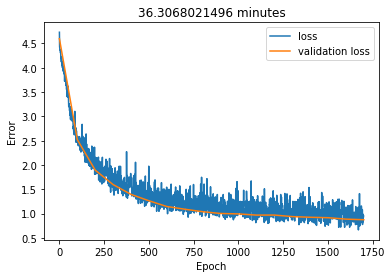

Starting epoch 	1701
Starting epoch 	1702
Starting epoch 	1703
Starting epoch 	1704
Starting epoch 	1705
Starting epoch 	1706
Starting epoch 	1707
Starting epoch 	1708
Starting epoch 	1709
Starting epoch 	1710
Starting epoch 	1711
Starting epoch 	1712
Starting epoch 	1713
Starting epoch 	1714
Starting epoch 	1715
Starting epoch 	1716
Starting epoch 	1717
Starting epoch 	1718
Starting epoch 	1719
Starting epoch 	1720
Starting epoch 	1721
Starting epoch 	1722
Starting epoch 	1723
Starting epoch 	1724
Starting epoch 	1725
Starting epoch 	1726
Starting epoch 	1727
Starting epoch 	1728
Starting epoch 	1729
Starting epoch 	1730
Starting epoch 	1731
Starting epoch 	1732
Starting epoch 	1733
Starting epoch 	1734
Starting epoch 	1735
Starting epoch 	1736
Starting epoch 	1737
Starting epoch 	1738
Starting epoch 	1739
Starting epoch 	1740
Starting epoch 	1741
Starting epoch 	1742
Starting epoch 	1743
Starting epoch 	1744
Starting epoch 	1745
Starting epoch 	1746
Starting epoch 	1747
Starting epoc

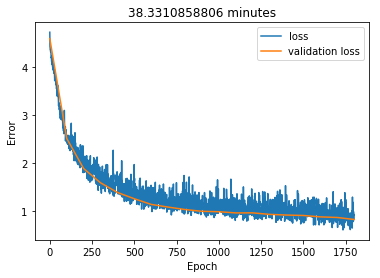

Starting epoch 	1801
Starting epoch 	1802
Starting epoch 	1803
Starting epoch 	1804
Starting epoch 	1805
Starting epoch 	1806
Starting epoch 	1807
Starting epoch 	1808
Starting epoch 	1809
Starting epoch 	1810
Starting epoch 	1811
Starting epoch 	1812
Starting epoch 	1813
Starting epoch 	1814
Starting epoch 	1815
Starting epoch 	1816
Starting epoch 	1817
Starting epoch 	1818
Starting epoch 	1819
Starting epoch 	1820
Starting epoch 	1821
Starting epoch 	1822
Starting epoch 	1823
Starting epoch 	1824
Starting epoch 	1825
Starting epoch 	1826
Starting epoch 	1827
Starting epoch 	1828
Starting epoch 	1829
Starting epoch 	1830
Starting epoch 	1831
Starting epoch 	1832
Starting epoch 	1833
Starting epoch 	1834
Starting epoch 	1835
Starting epoch 	1836
Starting epoch 	1837
Starting epoch 	1838
Starting epoch 	1839
Starting epoch 	1840
Starting epoch 	1841
Starting epoch 	1842
Starting epoch 	1843
Starting epoch 	1844
Starting epoch 	1845
Starting epoch 	1846
Starting epoch 	1847
Starting epoc

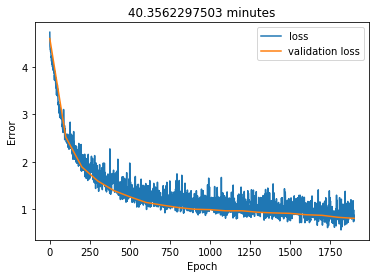

Starting epoch 	1901
Starting epoch 	1902
Starting epoch 	1903
Starting epoch 	1904
Starting epoch 	1905
Starting epoch 	1906
Starting epoch 	1907
Starting epoch 	1908
Starting epoch 	1909
Starting epoch 	1910
Starting epoch 	1911
Starting epoch 	1912
Starting epoch 	1913
Starting epoch 	1914
Starting epoch 	1915
Starting epoch 	1916
Starting epoch 	1917
Starting epoch 	1918
Starting epoch 	1919
Starting epoch 	1920
Starting epoch 	1921
Starting epoch 	1922
Starting epoch 	1923
Starting epoch 	1924
Starting epoch 	1925
Starting epoch 	1926
Starting epoch 	1927
Starting epoch 	1928
Starting epoch 	1929
Starting epoch 	1930
Starting epoch 	1931
Starting epoch 	1932
Starting epoch 	1933
Starting epoch 	1934
Starting epoch 	1935
Starting epoch 	1936
Starting epoch 	1937
Starting epoch 	1938
Starting epoch 	1939
Starting epoch 	1940
Starting epoch 	1941
Starting epoch 	1942
Starting epoch 	1943
Starting epoch 	1944
Starting epoch 	1945
Starting epoch 	1946
Starting epoch 	1947
Starting epoc

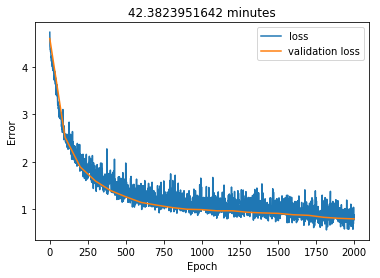

Starting epoch 	2001
Starting epoch 	2002
Starting epoch 	2003
Starting epoch 	2004
Starting epoch 	2005
Starting epoch 	2006
Starting epoch 	2007
Starting epoch 	2008
Starting epoch 	2009
Starting epoch 	2010
Starting epoch 	2011
Starting epoch 	2012
Starting epoch 	2013
Starting epoch 	2014
Starting epoch 	2015
Starting epoch 	2016
Starting epoch 	2017
Starting epoch 	2018
Starting epoch 	2019
Starting epoch 	2020
Starting epoch 	2021
Starting epoch 	2022
Starting epoch 	2023
Starting epoch 	2024
Starting epoch 	2025
Starting epoch 	2026
Starting epoch 	2027
Starting epoch 	2028
Starting epoch 	2029
Starting epoch 	2030
Starting epoch 	2031
Starting epoch 	2032
Starting epoch 	2033
Starting epoch 	2034
Starting epoch 	2035
Starting epoch 	2036
Starting epoch 	2037
Starting epoch 	2038
Starting epoch 	2039
Starting epoch 	2040
Starting epoch 	2041
Starting epoch 	2042
Starting epoch 	2043
Starting epoch 	2044
Starting epoch 	2045
Starting epoch 	2046
Starting epoch 	2047
Starting epoc

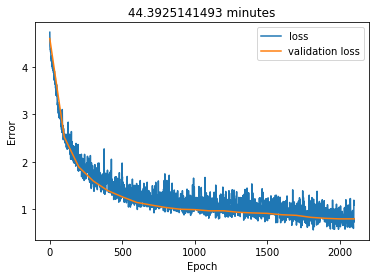

Starting epoch 	2101
Starting epoch 	2102
Starting epoch 	2103
Starting epoch 	2104
Starting epoch 	2105
Starting epoch 	2106
Starting epoch 	2107
Starting epoch 	2108
Starting epoch 	2109
Starting epoch 	2110
Starting epoch 	2111
Starting epoch 	2112
Starting epoch 	2113
Starting epoch 	2114
Starting epoch 	2115
Starting epoch 	2116
Starting epoch 	2117
Starting epoch 	2118
Starting epoch 	2119
Starting epoch 	2120
Starting epoch 	2121
Starting epoch 	2122
Starting epoch 	2123
Starting epoch 	2124
Starting epoch 	2125
Starting epoch 	2126
Starting epoch 	2127
Starting epoch 	2128
Starting epoch 	2129
Starting epoch 	2130
Starting epoch 	2131
Starting epoch 	2132
Starting epoch 	2133
Starting epoch 	2134
Starting epoch 	2135
Starting epoch 	2136
Starting epoch 	2137
Starting epoch 	2138
Starting epoch 	2139
Starting epoch 	2140
Starting epoch 	2141
Starting epoch 	2142
Starting epoch 	2143
Starting epoch 	2144
Starting epoch 	2145
Starting epoch 	2146
Starting epoch 	2147
Starting epoc

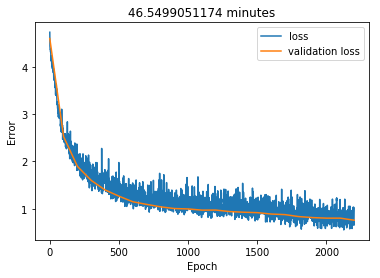

Starting epoch 	2201
Starting epoch 	2202
Starting epoch 	2203
Starting epoch 	2204
Starting epoch 	2205
Starting epoch 	2206
Starting epoch 	2207
Starting epoch 	2208
Starting epoch 	2209
Starting epoch 	2210
Starting epoch 	2211
Starting epoch 	2212
Starting epoch 	2213
Starting epoch 	2214
Starting epoch 	2215
Starting epoch 	2216
Starting epoch 	2217
Starting epoch 	2218
Starting epoch 	2219
Starting epoch 	2220
Starting epoch 	2221
Starting epoch 	2222
Starting epoch 	2223
Starting epoch 	2224
Starting epoch 	2225
Starting epoch 	2226
Starting epoch 	2227
Starting epoch 	2228
Starting epoch 	2229
Starting epoch 	2230
Starting epoch 	2231
Starting epoch 	2232
Starting epoch 	2233
Starting epoch 	2234
Starting epoch 	2235
Starting epoch 	2236
Starting epoch 	2237
Starting epoch 	2238
Starting epoch 	2239
Starting epoch 	2240
Starting epoch 	2241
Starting epoch 	2242
Starting epoch 	2243
Starting epoch 	2244
Starting epoch 	2245
Starting epoch 	2246
Starting epoch 	2247
Starting epoc

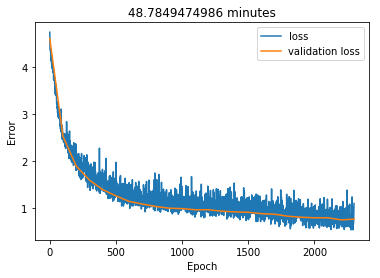

Starting epoch 	2301
Starting epoch 	2302
Starting epoch 	2303
Starting epoch 	2304
Starting epoch 	2305
Starting epoch 	2306
Starting epoch 	2307
Starting epoch 	2308
Starting epoch 	2309
Starting epoch 	2310
Starting epoch 	2311
Starting epoch 	2312
Starting epoch 	2313
Starting epoch 	2314
Starting epoch 	2315
Starting epoch 	2316
Starting epoch 	2317
Starting epoch 	2318
Starting epoch 	2319
Starting epoch 	2320
Starting epoch 	2321
Starting epoch 	2322
Starting epoch 	2323
Starting epoch 	2324
Starting epoch 	2325
Starting epoch 	2326
Starting epoch 	2327
Starting epoch 	2328
Starting epoch 	2329
Starting epoch 	2330
Starting epoch 	2331
Starting epoch 	2332
Starting epoch 	2333
Starting epoch 	2334
Starting epoch 	2335
Starting epoch 	2336
Starting epoch 	2337
Starting epoch 	2338
Starting epoch 	2339
Starting epoch 	2340
Starting epoch 	2341
Starting epoch 	2342
Starting epoch 	2343
Starting epoch 	2344
Starting epoch 	2345
Starting epoch 	2346
Starting epoch 	2347
Starting epoc

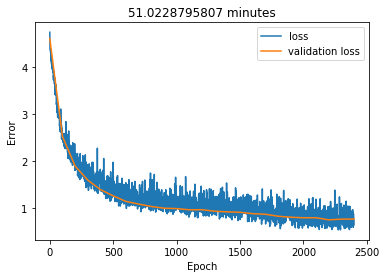

Starting epoch 	2401
Starting epoch 	2402
Starting epoch 	2403
Starting epoch 	2404
Starting epoch 	2405
Starting epoch 	2406
Starting epoch 	2407
Starting epoch 	2408
Starting epoch 	2409
Starting epoch 	2410
Starting epoch 	2411
Starting epoch 	2412
Starting epoch 	2413
Starting epoch 	2414
Starting epoch 	2415
Starting epoch 	2416
Starting epoch 	2417
Starting epoch 	2418
Starting epoch 	2419
Starting epoch 	2420
Starting epoch 	2421
Starting epoch 	2422
Starting epoch 	2423
Starting epoch 	2424
Starting epoch 	2425
Starting epoch 	2426
Starting epoch 	2427
Starting epoch 	2428
Starting epoch 	2429
Starting epoch 	2430
Starting epoch 	2431
Starting epoch 	2432
Starting epoch 	2433
Starting epoch 	2434
Starting epoch 	2435
Starting epoch 	2436
Starting epoch 	2437
Starting epoch 	2438
Starting epoch 	2439
Starting epoch 	2440
Starting epoch 	2441
Starting epoch 	2442
Starting epoch 	2443
Starting epoch 	2444
Starting epoch 	2445
Starting epoch 	2446
Starting epoch 	2447
Starting epoc

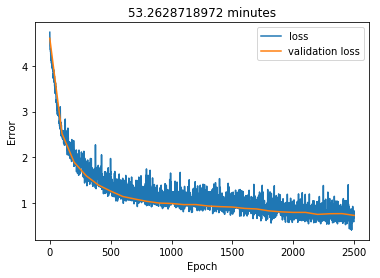

Starting epoch 	2501
Starting epoch 	2502
Starting epoch 	2503
Starting epoch 	2504
Starting epoch 	2505
Starting epoch 	2506
Starting epoch 	2507
Starting epoch 	2508
Starting epoch 	2509
Starting epoch 	2510
Starting epoch 	2511
Starting epoch 	2512
Starting epoch 	2513
Starting epoch 	2514
Starting epoch 	2515
Starting epoch 	2516
Starting epoch 	2517
Starting epoch 	2518
Starting epoch 	2519
Starting epoch 	2520
Starting epoch 	2521
Starting epoch 	2522
Starting epoch 	2523
Starting epoch 	2524
Starting epoch 	2525
Starting epoch 	2526
Starting epoch 	2527
Starting epoch 	2528
Starting epoch 	2529
Starting epoch 	2530
Starting epoch 	2531
Starting epoch 	2532
Starting epoch 	2533
Starting epoch 	2534
Starting epoch 	2535
Starting epoch 	2536
Starting epoch 	2537
Starting epoch 	2538
Starting epoch 	2539
Starting epoch 	2540
Starting epoch 	2541
Starting epoch 	2542
Starting epoch 	2543
Starting epoch 	2544
Starting epoch 	2545
Starting epoch 	2546
Starting epoch 	2547
Starting epoc

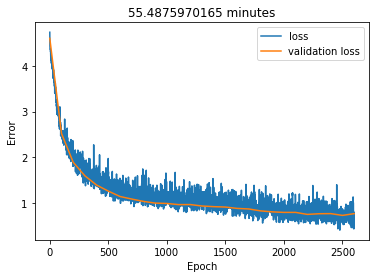

Starting epoch 	2601
Starting epoch 	2602
Starting epoch 	2603
Starting epoch 	2604
Starting epoch 	2605
Starting epoch 	2606
Starting epoch 	2607
Starting epoch 	2608
Starting epoch 	2609
Starting epoch 	2610
Starting epoch 	2611
Starting epoch 	2612
Starting epoch 	2613
Starting epoch 	2614
Starting epoch 	2615
Starting epoch 	2616
Starting epoch 	2617
Starting epoch 	2618
Starting epoch 	2619
Starting epoch 	2620
Starting epoch 	2621
Starting epoch 	2622
Starting epoch 	2623
Starting epoch 	2624
Starting epoch 	2625
Starting epoch 	2626
Starting epoch 	2627
Starting epoch 	2628
Starting epoch 	2629
Starting epoch 	2630
Starting epoch 	2631
Starting epoch 	2632
Starting epoch 	2633
Starting epoch 	2634
Starting epoch 	2635
Starting epoch 	2636
Starting epoch 	2637
Starting epoch 	2638
Starting epoch 	2639
Starting epoch 	2640
Starting epoch 	2641
Starting epoch 	2642
Starting epoch 	2643
Starting epoch 	2644
Starting epoch 	2645
Starting epoch 	2646
Starting epoch 	2647
Starting epoc

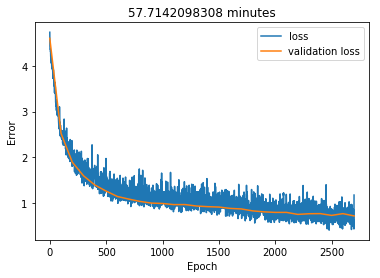

Starting epoch 	2701
Starting epoch 	2702
Starting epoch 	2703
Starting epoch 	2704
Starting epoch 	2705
Starting epoch 	2706
Starting epoch 	2707
Starting epoch 	2708
Starting epoch 	2709
Starting epoch 	2710
Starting epoch 	2711
Starting epoch 	2712
Starting epoch 	2713
Starting epoch 	2714
Starting epoch 	2715
Starting epoch 	2716
Starting epoch 	2717
Starting epoch 	2718
Starting epoch 	2719
Starting epoch 	2720
Starting epoch 	2721
Starting epoch 	2722
Starting epoch 	2723
Starting epoch 	2724
Starting epoch 	2725
Starting epoch 	2726
Starting epoch 	2727
Starting epoch 	2728
Starting epoch 	2729
Starting epoch 	2730
Starting epoch 	2731
Starting epoch 	2732
Starting epoch 	2733
Starting epoch 	2734
Starting epoch 	2735
Starting epoch 	2736
Starting epoch 	2737
Starting epoch 	2738
Starting epoch 	2739
Starting epoch 	2740
Starting epoch 	2741
Starting epoch 	2742
Starting epoch 	2743
Starting epoch 	2744
Starting epoch 	2745
Starting epoch 	2746
Starting epoch 	2747
Starting epoc

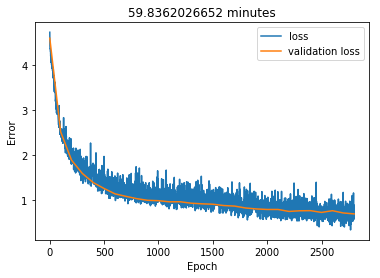

Starting epoch 	2801
Starting epoch 	2802
Starting epoch 	2803
Starting epoch 	2804
Starting epoch 	2805
Starting epoch 	2806
Starting epoch 	2807
Starting epoch 	2808
Starting epoch 	2809
Starting epoch 	2810
Starting epoch 	2811
Starting epoch 	2812
Starting epoch 	2813
Starting epoch 	2814
Starting epoch 	2815
Starting epoch 	2816
Starting epoch 	2817
Starting epoch 	2818
Starting epoch 	2819
Starting epoch 	2820
Starting epoch 	2821
Starting epoch 	2822
Starting epoch 	2823
Starting epoch 	2824
Starting epoch 	2825
Starting epoch 	2826
Starting epoch 	2827
Starting epoch 	2828
Starting epoch 	2829
Starting epoch 	2830
Starting epoch 	2831
Starting epoch 	2832
Starting epoch 	2833
Starting epoch 	2834
Starting epoch 	2835
Starting epoch 	2836
Starting epoch 	2837
Starting epoch 	2838
Starting epoch 	2839
Starting epoch 	2840
Starting epoch 	2841
Starting epoch 	2842
Starting epoch 	2843
Starting epoch 	2844
Starting epoch 	2845
Starting epoch 	2846
Starting epoch 	2847
Starting epoc

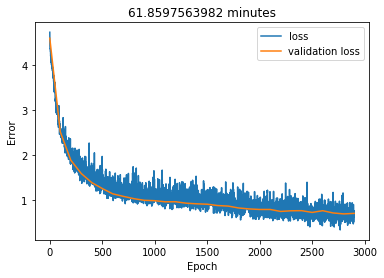

Starting epoch 	2901
Starting epoch 	2902
Starting epoch 	2903
Starting epoch 	2904
Starting epoch 	2905
Starting epoch 	2906
Starting epoch 	2907
Starting epoch 	2908
Starting epoch 	2909
Starting epoch 	2910
Starting epoch 	2911
Starting epoch 	2912
Starting epoch 	2913
Starting epoch 	2914
Starting epoch 	2915
Starting epoch 	2916
Starting epoch 	2917
Starting epoch 	2918
Starting epoch 	2919
Starting epoch 	2920
Starting epoch 	2921
Starting epoch 	2922
Starting epoch 	2923
Starting epoch 	2924
Starting epoch 	2925
Starting epoch 	2926
Starting epoch 	2927
Starting epoch 	2928
Starting epoch 	2929
Starting epoch 	2930
Starting epoch 	2931
Starting epoch 	2932
Starting epoch 	2933
Starting epoch 	2934
Starting epoch 	2935
Starting epoch 	2936
Starting epoch 	2937
Starting epoch 	2938
Starting epoch 	2939
Starting epoch 	2940
Starting epoch 	2941
Starting epoch 	2942
Starting epoch 	2943
Starting epoch 	2944
Starting epoch 	2945
Starting epoch 	2946
Starting epoch 	2947
Starting epoc

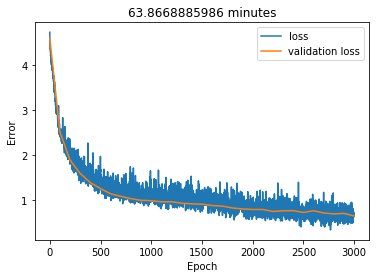

Starting epoch 	3001
Starting epoch 	3002
Starting epoch 	3003
Starting epoch 	3004
Starting epoch 	3005
Starting epoch 	3006
Starting epoch 	3007
Starting epoch 	3008
Starting epoch 	3009
Starting epoch 	3010
Starting epoch 	3011
Starting epoch 	3012
Starting epoch 	3013
Starting epoch 	3014
Starting epoch 	3015
Starting epoch 	3016
Starting epoch 	3017
Starting epoch 	3018
Starting epoch 	3019
Starting epoch 	3020
Starting epoch 	3021
Starting epoch 	3022
Starting epoch 	3023
Starting epoch 	3024
Starting epoch 	3025
Starting epoch 	3026
Starting epoch 	3027
Starting epoch 	3028
Starting epoch 	3029
Starting epoch 	3030
Starting epoch 	3031
Starting epoch 	3032
Starting epoch 	3033
Starting epoch 	3034
Starting epoch 	3035
Starting epoch 	3036
Starting epoch 	3037
Starting epoch 	3038
Starting epoch 	3039
Starting epoch 	3040
Starting epoch 	3041
Starting epoch 	3042
Starting epoch 	3043
Starting epoch 	3044
Starting epoch 	3045
Starting epoch 	3046
Starting epoch 	3047
Starting epoc

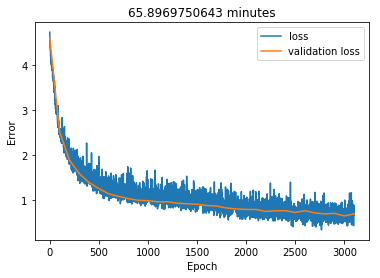

Starting epoch 	3101
Starting epoch 	3102
Starting epoch 	3103
Starting epoch 	3104
Starting epoch 	3105
Starting epoch 	3106
Starting epoch 	3107
Starting epoch 	3108
Starting epoch 	3109
Starting epoch 	3110
Starting epoch 	3111
Starting epoch 	3112
Starting epoch 	3113
Starting epoch 	3114
Starting epoch 	3115
Starting epoch 	3116
Starting epoch 	3117
Starting epoch 	3118
Starting epoch 	3119
Starting epoch 	3120
Starting epoch 	3121
Starting epoch 	3122
Starting epoch 	3123
Starting epoch 	3124
Starting epoch 	3125
Starting epoch 	3126
Starting epoch 	3127
Starting epoch 	3128
Starting epoch 	3129
Starting epoch 	3130
Starting epoch 	3131
Starting epoch 	3132
Starting epoch 	3133
Starting epoch 	3134
Starting epoch 	3135
Starting epoch 	3136
Starting epoch 	3137
Starting epoch 	3138
Starting epoch 	3139
Starting epoch 	3140
Starting epoch 	3141
Starting epoch 	3142
Starting epoch 	3143
Starting epoch 	3144
Starting epoch 	3145
Starting epoch 	3146
Starting epoch 	3147
Starting epoc

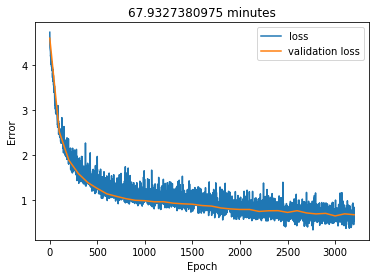

Starting epoch 	3201
Starting epoch 	3202
Starting epoch 	3203
Starting epoch 	3204
Starting epoch 	3205
Starting epoch 	3206
Starting epoch 	3207
Starting epoch 	3208
Starting epoch 	3209
Starting epoch 	3210
Starting epoch 	3211
Starting epoch 	3212
Starting epoch 	3213
Starting epoch 	3214
Starting epoch 	3215
Starting epoch 	3216
Starting epoch 	3217
Starting epoch 	3218
Starting epoch 	3219
Starting epoch 	3220
Starting epoch 	3221
Starting epoch 	3222
Starting epoch 	3223
Starting epoch 	3224
Starting epoch 	3225
Starting epoch 	3226
Starting epoch 	3227
Starting epoch 	3228
Starting epoch 	3229
Starting epoch 	3230
Starting epoch 	3231
Starting epoch 	3232
Starting epoch 	3233
Starting epoch 	3234
Starting epoch 	3235
Starting epoch 	3236
Starting epoch 	3237
Starting epoch 	3238
Starting epoch 	3239
Starting epoch 	3240
Starting epoch 	3241
Starting epoch 	3242
Starting epoch 	3243
Starting epoch 	3244
Starting epoch 	3245
Starting epoch 	3246
Starting epoch 	3247
Starting epoc

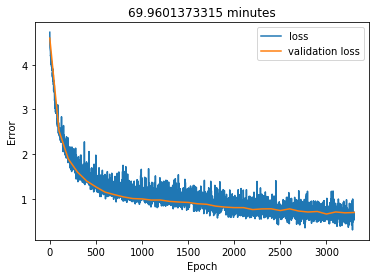

Starting epoch 	3301
Starting epoch 	3302
Starting epoch 	3303
Starting epoch 	3304
Starting epoch 	3305
Starting epoch 	3306
Starting epoch 	3307
Starting epoch 	3308
Starting epoch 	3309
Starting epoch 	3310
Starting epoch 	3311
Starting epoch 	3312
Starting epoch 	3313
Starting epoch 	3314
Starting epoch 	3315
Starting epoch 	3316
Starting epoch 	3317
Starting epoch 	3318
Starting epoch 	3319
Starting epoch 	3320
Starting epoch 	3321
Starting epoch 	3322
Starting epoch 	3323
Starting epoch 	3324
Starting epoch 	3325
Starting epoch 	3326
Starting epoch 	3327
Starting epoch 	3328
Starting epoch 	3329
Starting epoch 	3330
Starting epoch 	3331
Starting epoch 	3332
Starting epoch 	3333
Starting epoch 	3334
Starting epoch 	3335
Starting epoch 	3336
Starting epoch 	3337
Starting epoch 	3338
Starting epoch 	3339
Starting epoch 	3340
Starting epoch 	3341
Starting epoch 	3342
Starting epoch 	3343
Starting epoch 	3344
Starting epoch 	3345
Starting epoch 	3346
Starting epoch 	3347
Starting epoc

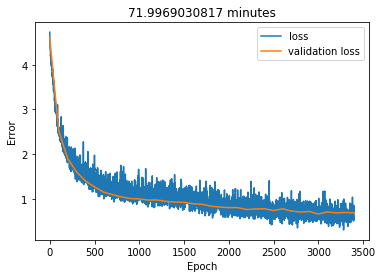

Starting epoch 	3401
Starting epoch 	3402
Starting epoch 	3403
Starting epoch 	3404
Starting epoch 	3405
Starting epoch 	3406
Starting epoch 	3407
Starting epoch 	3408
Starting epoch 	3409
Starting epoch 	3410
Starting epoch 	3411
Starting epoch 	3412
Starting epoch 	3413
Starting epoch 	3414
Starting epoch 	3415
Starting epoch 	3416
Starting epoch 	3417
Starting epoch 	3418
Starting epoch 	3419
Starting epoch 	3420
Starting epoch 	3421
Starting epoch 	3422
Starting epoch 	3423
Starting epoch 	3424
Starting epoch 	3425
Starting epoch 	3426
Starting epoch 	3427
Starting epoch 	3428
Starting epoch 	3429
Starting epoch 	3430
Starting epoch 	3431
Starting epoch 	3432
Starting epoch 	3433
Starting epoch 	3434
Starting epoch 	3435
Starting epoch 	3436
Starting epoch 	3437
Starting epoch 	3438
Starting epoch 	3439
Starting epoch 	3440
Starting epoch 	3441
Starting epoch 	3442
Starting epoch 	3443
Starting epoch 	3444
Starting epoch 	3445
Starting epoch 	3446
Starting epoch 	3447
Starting epoc

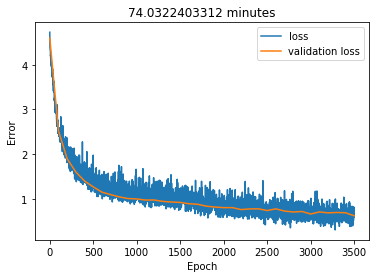

Starting epoch 	3501
Starting epoch 	3502
Starting epoch 	3503
Starting epoch 	3504
Starting epoch 	3505
Starting epoch 	3506
Starting epoch 	3507
Starting epoch 	3508
Starting epoch 	3509
Starting epoch 	3510
Starting epoch 	3511
Starting epoch 	3512
Starting epoch 	3513
Starting epoch 	3514
Starting epoch 	3515
Starting epoch 	3516
Starting epoch 	3517
Starting epoch 	3518
Starting epoch 	3519
Starting epoch 	3520
Starting epoch 	3521
Starting epoch 	3522
Starting epoch 	3523
Starting epoch 	3524
Starting epoch 	3525
Starting epoch 	3526
Starting epoch 	3527
Starting epoch 	3528
Starting epoch 	3529
Starting epoch 	3530
Starting epoch 	3531
Starting epoch 	3532
Starting epoch 	3533
Starting epoch 	3534
Starting epoch 	3535
Starting epoch 	3536
Starting epoch 	3537
Starting epoch 	3538
Starting epoch 	3539
Starting epoch 	3540
Starting epoch 	3541
Starting epoch 	3542
Starting epoch 	3543
Starting epoch 	3544
Starting epoch 	3545
Starting epoch 	3546
Starting epoch 	3547
Starting epoc

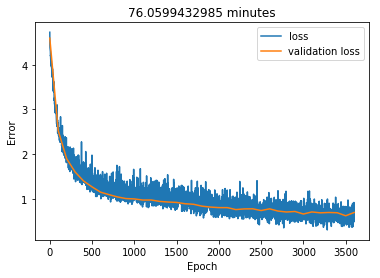

Starting epoch 	3601
Starting epoch 	3602
Starting epoch 	3603
Starting epoch 	3604
Starting epoch 	3605
Starting epoch 	3606
Starting epoch 	3607
Starting epoch 	3608
Starting epoch 	3609
Starting epoch 	3610
Starting epoch 	3611
Starting epoch 	3612
Starting epoch 	3613
Starting epoch 	3614
Starting epoch 	3615
Starting epoch 	3616
Starting epoch 	3617
Starting epoch 	3618
Starting epoch 	3619
Starting epoch 	3620
Starting epoch 	3621
Starting epoch 	3622
Starting epoch 	3623
Starting epoch 	3624
Starting epoch 	3625
Starting epoch 	3626
Starting epoch 	3627
Starting epoch 	3628
Starting epoch 	3629
Starting epoch 	3630
Starting epoch 	3631
Starting epoch 	3632
Starting epoch 	3633
Starting epoch 	3634
Starting epoch 	3635
Starting epoch 	3636
Starting epoch 	3637
Starting epoch 	3638
Starting epoch 	3639
Starting epoch 	3640
Starting epoch 	3641
Starting epoch 	3642
Starting epoch 	3643
Starting epoch 	3644
Starting epoch 	3645
Starting epoch 	3646
Starting epoch 	3647
Starting epoc

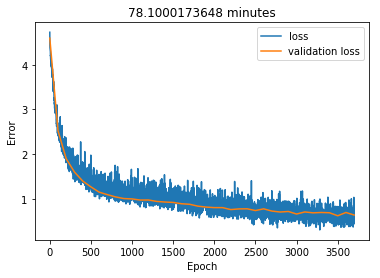

Starting epoch 	3701
Starting epoch 	3702
Starting epoch 	3703
Starting epoch 	3704
Starting epoch 	3705
Starting epoch 	3706
Starting epoch 	3707
Starting epoch 	3708
Starting epoch 	3709
Starting epoch 	3710
Starting epoch 	3711
Starting epoch 	3712
Starting epoch 	3713
Starting epoch 	3714
Starting epoch 	3715
Starting epoch 	3716
Starting epoch 	3717
Starting epoch 	3718
Starting epoch 	3719
Starting epoch 	3720
Starting epoch 	3721
Starting epoch 	3722
Starting epoch 	3723
Starting epoch 	3724
Starting epoch 	3725
Starting epoch 	3726
Starting epoch 	3727
Starting epoch 	3728
Starting epoch 	3729
Starting epoch 	3730
Starting epoch 	3731
Starting epoch 	3732
Starting epoch 	3733
Starting epoch 	3734
Starting epoch 	3735
Starting epoch 	3736
Starting epoch 	3737
Starting epoch 	3738
Starting epoch 	3739
Starting epoch 	3740
Starting epoch 	3741
Starting epoch 	3742
Starting epoch 	3743
Starting epoch 	3744
Starting epoch 	3745
Starting epoch 	3746
Starting epoch 	3747
Starting epoc

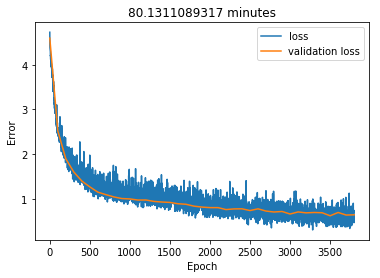

Starting epoch 	3801
Starting epoch 	3802
Starting epoch 	3803
Starting epoch 	3804
Starting epoch 	3805
Starting epoch 	3806
Starting epoch 	3807
Starting epoch 	3808
Starting epoch 	3809
Starting epoch 	3810
Starting epoch 	3811
Starting epoch 	3812
Starting epoch 	3813
Starting epoch 	3814
Starting epoch 	3815
Starting epoch 	3816
Starting epoch 	3817
Starting epoch 	3818
Starting epoch 	3819
Starting epoch 	3820
Starting epoch 	3821
Starting epoch 	3822
Starting epoch 	3823
Starting epoch 	3824
Starting epoch 	3825
Starting epoch 	3826
Starting epoch 	3827
Starting epoch 	3828
Starting epoch 	3829
Starting epoch 	3830
Starting epoch 	3831
Starting epoch 	3832
Starting epoch 	3833
Starting epoch 	3834
Starting epoch 	3835
Starting epoch 	3836
Starting epoch 	3837
Starting epoch 	3838
Starting epoch 	3839
Starting epoch 	3840
Starting epoch 	3841
Starting epoch 	3842
Starting epoch 	3843
Starting epoch 	3844
Starting epoch 	3845
Starting epoch 	3846
Starting epoch 	3847
Starting epoc

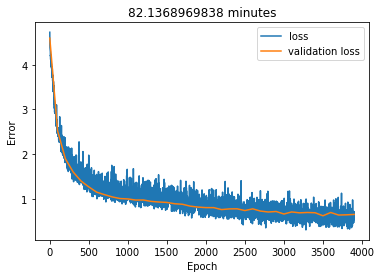

Starting epoch 	3901
Starting epoch 	3902
Starting epoch 	3903
Starting epoch 	3904
Starting epoch 	3905
Starting epoch 	3906
Starting epoch 	3907
Starting epoch 	3908
Starting epoch 	3909
Starting epoch 	3910
Starting epoch 	3911
Starting epoch 	3912
Starting epoch 	3913
Starting epoch 	3914
Starting epoch 	3915
Starting epoch 	3916
Starting epoch 	3917
Starting epoch 	3918
Starting epoch 	3919
Starting epoch 	3920
Starting epoch 	3921
Starting epoch 	3922
Starting epoch 	3923
Starting epoch 	3924
Starting epoch 	3925
Starting epoch 	3926
Starting epoch 	3927
Starting epoch 	3928
Starting epoch 	3929
Starting epoch 	3930
Starting epoch 	3931
Starting epoch 	3932
Starting epoch 	3933
Starting epoch 	3934
Starting epoch 	3935
Starting epoch 	3936
Starting epoch 	3937
Starting epoch 	3938
Starting epoch 	3939
Starting epoch 	3940
Starting epoch 	3941
Starting epoch 	3942
Starting epoch 	3943
Starting epoch 	3944
Starting epoch 	3945
Starting epoch 	3946
Starting epoch 	3947
Starting epoc

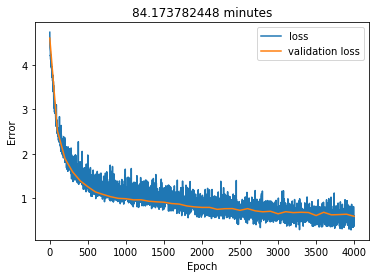

Starting epoch 	4001
Starting epoch 	4002
Starting epoch 	4003
Starting epoch 	4004
Starting epoch 	4005
Starting epoch 	4006
Starting epoch 	4007
Starting epoch 	4008
Starting epoch 	4009
Starting epoch 	4010
Starting epoch 	4011
Starting epoch 	4012
Starting epoch 	4013
Starting epoch 	4014
Starting epoch 	4015
Starting epoch 	4016
Starting epoch 	4017
Starting epoch 	4018
Starting epoch 	4019
Starting epoch 	4020
Starting epoch 	4021
Starting epoch 	4022
Starting epoch 	4023
Starting epoch 	4024
Starting epoch 	4025
Starting epoch 	4026
Starting epoch 	4027
Starting epoch 	4028
Starting epoch 	4029
Starting epoch 	4030
Starting epoch 	4031
Starting epoch 	4032
Starting epoch 	4033
Starting epoch 	4034
Starting epoch 	4035
Starting epoch 	4036
Starting epoch 	4037
Starting epoch 	4038
Starting epoch 	4039
Starting epoch 	4040
Starting epoch 	4041
Starting epoch 	4042
Starting epoch 	4043
Starting epoch 	4044
Starting epoch 	4045
Starting epoch 	4046
Starting epoch 	4047
Starting epoc

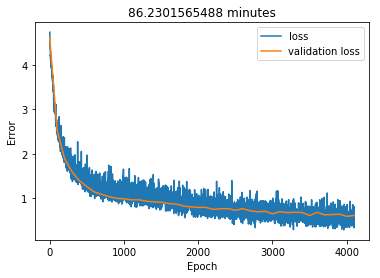

Starting epoch 	4101
Starting epoch 	4102
Starting epoch 	4103
Starting epoch 	4104
Starting epoch 	4105
Starting epoch 	4106
Starting epoch 	4107
Starting epoch 	4108
Starting epoch 	4109
Starting epoch 	4110
Starting epoch 	4111
Starting epoch 	4112
Starting epoch 	4113
Starting epoch 	4114
Starting epoch 	4115
Starting epoch 	4116
Starting epoch 	4117
Starting epoch 	4118
Starting epoch 	4119
Starting epoch 	4120
Starting epoch 	4121
Starting epoch 	4122
Starting epoch 	4123
Starting epoch 	4124
Starting epoch 	4125
Starting epoch 	4126
Starting epoch 	4127
Starting epoch 	4128
Starting epoch 	4129
Starting epoch 	4130
Starting epoch 	4131
Starting epoch 	4132
Starting epoch 	4133
Starting epoch 	4134
Starting epoch 	4135
Starting epoch 	4136
Starting epoch 	4137
Starting epoch 	4138
Starting epoch 	4139
Starting epoch 	4140
Starting epoch 	4141
Starting epoch 	4142
Starting epoch 	4143
Starting epoch 	4144
Starting epoch 	4145
Starting epoch 	4146
Starting epoch 	4147
Starting epoc

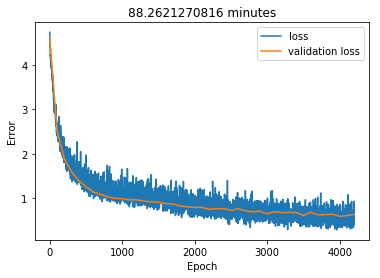

Starting epoch 	4201
Starting epoch 	4202
Starting epoch 	4203
Starting epoch 	4204
Starting epoch 	4205
Starting epoch 	4206
Starting epoch 	4207
Starting epoch 	4208
Starting epoch 	4209
Starting epoch 	4210
Starting epoch 	4211
Starting epoch 	4212
Starting epoch 	4213
Starting epoch 	4214
Starting epoch 	4215
Starting epoch 	4216
Starting epoch 	4217
Starting epoch 	4218
Starting epoch 	4219
Starting epoch 	4220
Starting epoch 	4221
Starting epoch 	4222
Starting epoch 	4223
Starting epoch 	4224
Starting epoch 	4225
Starting epoch 	4226
Starting epoch 	4227
Starting epoch 	4228
Starting epoch 	4229
Starting epoch 	4230
Starting epoch 	4231
Starting epoch 	4232
Starting epoch 	4233
Starting epoch 	4234
Starting epoch 	4235
Starting epoch 	4236
Starting epoch 	4237
Starting epoch 	4238
Starting epoch 	4239
Starting epoch 	4240
Starting epoch 	4241
Starting epoch 	4242
Starting epoch 	4243
Starting epoch 	4244
Starting epoch 	4245
Starting epoch 	4246
Starting epoch 	4247
Starting epoc

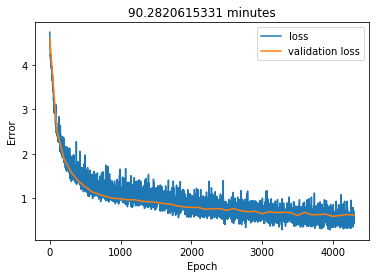

Starting epoch 	4301
Starting epoch 	4302
Starting epoch 	4303
Starting epoch 	4304
Starting epoch 	4305
Starting epoch 	4306
Starting epoch 	4307
Starting epoch 	4308
Starting epoch 	4309
Starting epoch 	4310
Starting epoch 	4311
Starting epoch 	4312
Starting epoch 	4313
Starting epoch 	4314
Starting epoch 	4315
Starting epoch 	4316
Starting epoch 	4317
Starting epoch 	4318
Starting epoch 	4319
Starting epoch 	4320
Starting epoch 	4321
Starting epoch 	4322
Starting epoch 	4323
Starting epoch 	4324
Starting epoch 	4325
Starting epoch 	4326
Starting epoch 	4327
Starting epoch 	4328
Starting epoch 	4329
Starting epoch 	4330
Starting epoch 	4331
Starting epoch 	4332
Starting epoch 	4333
Starting epoch 	4334
Starting epoch 	4335
Starting epoch 	4336
Starting epoch 	4337
Starting epoch 	4338
Starting epoch 	4339
Starting epoch 	4340
Starting epoch 	4341
Starting epoch 	4342
Starting epoch 	4343
Starting epoch 	4344
Starting epoch 	4345
Starting epoch 	4346
Starting epoch 	4347
Starting epoc

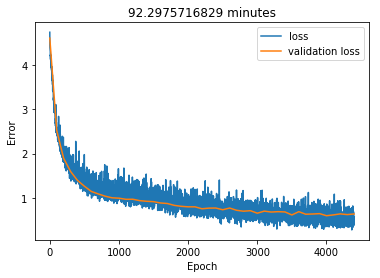

Starting epoch 	4401
Starting epoch 	4402
Starting epoch 	4403
Starting epoch 	4404
Starting epoch 	4405
Starting epoch 	4406
Starting epoch 	4407
Starting epoch 	4408
Starting epoch 	4409
Starting epoch 	4410
Starting epoch 	4411
Starting epoch 	4412
Starting epoch 	4413
Starting epoch 	4414
Starting epoch 	4415
Starting epoch 	4416
Starting epoch 	4417
Starting epoch 	4418
Starting epoch 	4419
Starting epoch 	4420
Starting epoch 	4421
Starting epoch 	4422
Starting epoch 	4423
Starting epoch 	4424
Starting epoch 	4425
Starting epoch 	4426
Starting epoch 	4427
Starting epoch 	4428
Starting epoch 	4429
Starting epoch 	4430
Starting epoch 	4431
Starting epoch 	4432
Starting epoch 	4433
Starting epoch 	4434
Starting epoch 	4435
Starting epoch 	4436
Starting epoch 	4437
Starting epoch 	4438
Starting epoch 	4439
Starting epoch 	4440
Starting epoch 	4441
Starting epoch 	4442
Starting epoch 	4443
Starting epoch 	4444
Starting epoch 	4445
Starting epoch 	4446
Starting epoch 	4447
Starting epoc

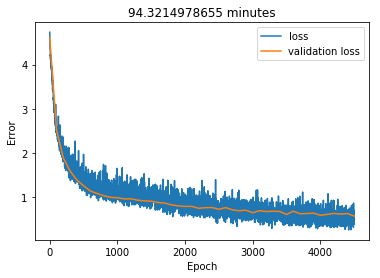

Starting epoch 	4501
Starting epoch 	4502
Starting epoch 	4503
Starting epoch 	4504
Starting epoch 	4505
Starting epoch 	4506
Starting epoch 	4507
Starting epoch 	4508
Starting epoch 	4509
Starting epoch 	4510
Starting epoch 	4511
Starting epoch 	4512
Starting epoch 	4513
Starting epoch 	4514
Starting epoch 	4515
Starting epoch 	4516
Starting epoch 	4517
Starting epoch 	4518
Starting epoch 	4519
Starting epoch 	4520
Starting epoch 	4521
Starting epoch 	4522
Starting epoch 	4523
Starting epoch 	4524
Starting epoch 	4525
Starting epoch 	4526
Starting epoch 	4527
Starting epoch 	4528
Starting epoch 	4529
Starting epoch 	4530
Starting epoch 	4531
Starting epoch 	4532
Starting epoch 	4533
Starting epoch 	4534
Starting epoch 	4535
Starting epoch 	4536
Starting epoch 	4537
Starting epoch 	4538
Starting epoch 	4539
Starting epoch 	4540
Starting epoch 	4541
Starting epoch 	4542
Starting epoch 	4543
Starting epoch 	4544
Starting epoch 	4545
Starting epoch 	4546
Starting epoch 	4547
Starting epoc

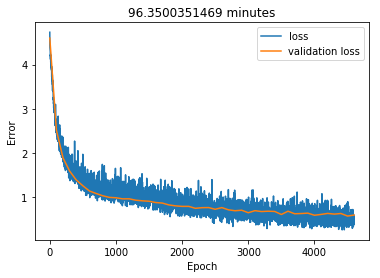

Starting epoch 	4601
Starting epoch 	4602
Starting epoch 	4603
Starting epoch 	4604
Starting epoch 	4605
Starting epoch 	4606
Starting epoch 	4607
Starting epoch 	4608
Starting epoch 	4609
Starting epoch 	4610
Starting epoch 	4611
Starting epoch 	4612
Starting epoch 	4613
Starting epoch 	4614
Starting epoch 	4615
Starting epoch 	4616
Starting epoch 	4617
Starting epoch 	4618
Starting epoch 	4619
Starting epoch 	4620
Starting epoch 	4621
Starting epoch 	4622
Starting epoch 	4623
Starting epoch 	4624
Starting epoch 	4625
Starting epoch 	4626
Starting epoch 	4627
Starting epoch 	4628
Starting epoch 	4629
Starting epoch 	4630
Starting epoch 	4631
Starting epoch 	4632
Starting epoch 	4633
Starting epoch 	4634
Starting epoch 	4635
Starting epoch 	4636
Starting epoch 	4637
Starting epoch 	4638
Starting epoch 	4639
Starting epoch 	4640
Starting epoch 	4641
Starting epoch 	4642
Starting epoch 	4643
Starting epoch 	4644
Starting epoch 	4645
Starting epoch 	4646
Starting epoch 	4647
Starting epoc

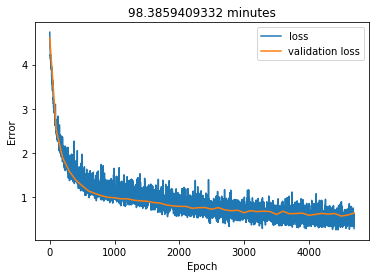

Starting epoch 	4701
Starting epoch 	4702
Starting epoch 	4703
Starting epoch 	4704
Starting epoch 	4705
Starting epoch 	4706
Starting epoch 	4707
Starting epoch 	4708
Starting epoch 	4709
Starting epoch 	4710
Starting epoch 	4711
Starting epoch 	4712
Starting epoch 	4713
Starting epoch 	4714
Starting epoch 	4715
Starting epoch 	4716
Starting epoch 	4717
Starting epoch 	4718
Starting epoch 	4719
Starting epoch 	4720
Starting epoch 	4721
Starting epoch 	4722
Starting epoch 	4723
Starting epoch 	4724
Starting epoch 	4725
Starting epoch 	4726
Starting epoch 	4727
Starting epoch 	4728
Starting epoch 	4729
Starting epoch 	4730
Starting epoch 	4731
Starting epoch 	4732
Starting epoch 	4733
Starting epoch 	4734
Starting epoch 	4735
Starting epoch 	4736
Starting epoch 	4737
Starting epoch 	4738
Starting epoch 	4739
Starting epoch 	4740
Starting epoch 	4741
Starting epoch 	4742
Starting epoch 	4743
Starting epoch 	4744
Starting epoch 	4745
Starting epoch 	4746
Starting epoch 	4747
Starting epoc

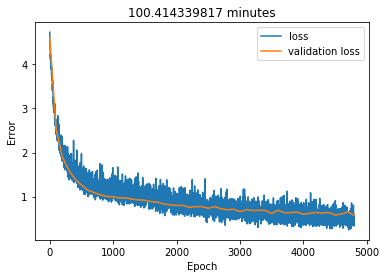

Starting epoch 	4801
Starting epoch 	4802
Starting epoch 	4803
Starting epoch 	4804
Starting epoch 	4805
Starting epoch 	4806
Starting epoch 	4807
Starting epoch 	4808
Starting epoch 	4809
Starting epoch 	4810
Starting epoch 	4811
Starting epoch 	4812
Starting epoch 	4813
Starting epoch 	4814
Starting epoch 	4815
Starting epoch 	4816
Starting epoch 	4817
Starting epoch 	4818
Starting epoch 	4819
Starting epoch 	4820
Starting epoch 	4821
Starting epoch 	4822
Starting epoch 	4823
Starting epoch 	4824
Starting epoch 	4825
Starting epoch 	4826
Starting epoch 	4827
Starting epoch 	4828
Starting epoch 	4829
Starting epoch 	4830
Starting epoch 	4831
Starting epoch 	4832
Starting epoch 	4833
Starting epoch 	4834
Starting epoch 	4835
Starting epoch 	4836
Starting epoch 	4837
Starting epoch 	4838
Starting epoch 	4839
Starting epoch 	4840
Starting epoch 	4841
Starting epoch 	4842
Starting epoch 	4843
Starting epoch 	4844
Starting epoch 	4845
Starting epoch 	4846
Starting epoch 	4847
Starting epoc

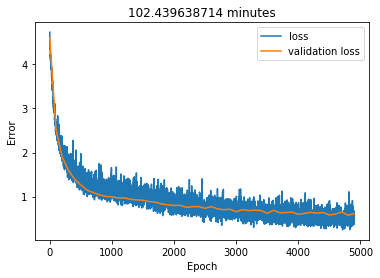

Starting epoch 	4901
Starting epoch 	4902
Starting epoch 	4903
Starting epoch 	4904
Starting epoch 	4905
Starting epoch 	4906
Starting epoch 	4907
Starting epoch 	4908
Starting epoch 	4909
Starting epoch 	4910
Starting epoch 	4911
Starting epoch 	4912
Starting epoch 	4913
Starting epoch 	4914
Starting epoch 	4915
Starting epoch 	4916
Starting epoch 	4917
Starting epoch 	4918
Starting epoch 	4919
Starting epoch 	4920
Starting epoch 	4921
Starting epoch 	4922
Starting epoch 	4923
Starting epoch 	4924
Starting epoch 	4925
Starting epoch 	4926
Starting epoch 	4927
Starting epoch 	4928
Starting epoch 	4929
Starting epoch 	4930
Starting epoch 	4931
Starting epoch 	4932
Starting epoch 	4933
Starting epoch 	4934
Starting epoch 	4935
Starting epoch 	4936
Starting epoch 	4937
Starting epoch 	4938
Starting epoch 	4939
Starting epoch 	4940
Starting epoch 	4941
Starting epoch 	4942
Starting epoch 	4943
Starting epoch 	4944
Starting epoch 	4945
Starting epoch 	4946
Starting epoch 	4947
Starting epoc

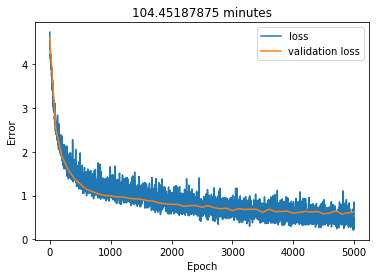

Starting epoch 	5001
Starting epoch 	5002
Starting epoch 	5003
Starting epoch 	5004
Starting epoch 	5005
Starting epoch 	5006
Starting epoch 	5007
Starting epoch 	5008
Starting epoch 	5009
Starting epoch 	5010
Starting epoch 	5011
Starting epoch 	5012
Starting epoch 	5013
Starting epoch 	5014
Starting epoch 	5015
Starting epoch 	5016
Starting epoch 	5017
Starting epoch 	5018
Starting epoch 	5019
Starting epoch 	5020
Starting epoch 	5021
Starting epoch 	5022
Starting epoch 	5023
Starting epoch 	5024
Starting epoch 	5025
Starting epoch 	5026
Starting epoch 	5027
Starting epoch 	5028
Starting epoch 	5029
Starting epoch 	5030
Starting epoch 	5031
Starting epoch 	5032
Starting epoch 	5033
Starting epoch 	5034
Starting epoch 	5035
Starting epoch 	5036
Starting epoch 	5037
Starting epoch 	5038
Starting epoch 	5039
Starting epoch 	5040
Starting epoch 	5041
Starting epoch 	5042
Starting epoch 	5043
Starting epoch 	5044
Starting epoch 	5045
Starting epoch 	5046
Starting epoch 	5047
Starting epoc

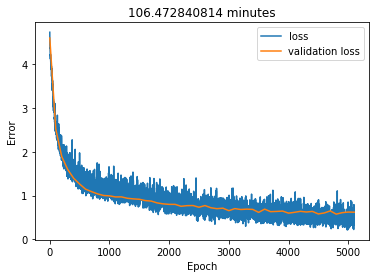

Starting epoch 	5101
Starting epoch 	5102
Starting epoch 	5103
Starting epoch 	5104
Starting epoch 	5105
Starting epoch 	5106
Starting epoch 	5107
Starting epoch 	5108
Starting epoch 	5109
Starting epoch 	5110
Starting epoch 	5111
Starting epoch 	5112
Starting epoch 	5113
Starting epoch 	5114
Starting epoch 	5115
Starting epoch 	5116
Starting epoch 	5117
Starting epoch 	5118
Starting epoch 	5119
Starting epoch 	5120
Starting epoch 	5121
Starting epoch 	5122
Starting epoch 	5123
Starting epoch 	5124
Starting epoch 	5125
Starting epoch 	5126
Starting epoch 	5127
Starting epoch 	5128
Starting epoch 	5129
Starting epoch 	5130
Starting epoch 	5131
Starting epoch 	5132
Starting epoch 	5133
Starting epoch 	5134
Starting epoch 	5135
Starting epoch 	5136
Starting epoch 	5137
Starting epoch 	5138
Starting epoch 	5139
Starting epoch 	5140
Starting epoch 	5141
Starting epoch 	5142
Starting epoch 	5143
Starting epoch 	5144
Starting epoch 	5145
Starting epoch 	5146
Starting epoch 	5147
Starting epoc

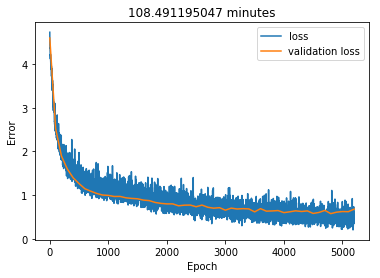

Starting epoch 	5201
Starting epoch 	5202
Starting epoch 	5203
Starting epoch 	5204
Starting epoch 	5205
Starting epoch 	5206
Starting epoch 	5207
Starting epoch 	5208
Starting epoch 	5209
Starting epoch 	5210
Starting epoch 	5211
Starting epoch 	5212
Starting epoch 	5213
Starting epoch 	5214
Starting epoch 	5215
Starting epoch 	5216
Starting epoch 	5217
Starting epoch 	5218
Starting epoch 	5219
Starting epoch 	5220
Starting epoch 	5221
Starting epoch 	5222
Starting epoch 	5223
Starting epoch 	5224
Starting epoch 	5225
Starting epoch 	5226
Starting epoch 	5227
Starting epoch 	5228
Starting epoch 	5229
Starting epoch 	5230
Starting epoch 	5231
Starting epoch 	5232
Starting epoch 	5233
Starting epoch 	5234
Starting epoch 	5235
Starting epoch 	5236
Starting epoch 	5237
Starting epoch 	5238
Starting epoch 	5239
Starting epoch 	5240
Starting epoch 	5241
Starting epoch 	5242
Starting epoch 	5243
Starting epoch 	5244
Starting epoch 	5245
Starting epoch 	5246
Starting epoch 	5247
Starting epoc

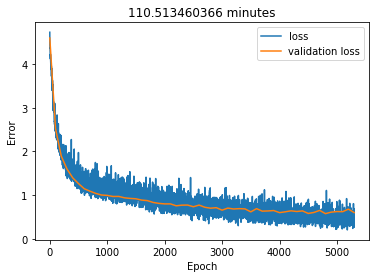

Starting epoch 	5301
Starting epoch 	5302
Starting epoch 	5303
Starting epoch 	5304
Starting epoch 	5305
Starting epoch 	5306
Starting epoch 	5307
Starting epoch 	5308
Starting epoch 	5309
Starting epoch 	5310
Starting epoch 	5311
Starting epoch 	5312
Starting epoch 	5313
Starting epoch 	5314
Starting epoch 	5315
Starting epoch 	5316
Starting epoch 	5317
Starting epoch 	5318
Starting epoch 	5319
Starting epoch 	5320
Starting epoch 	5321
Starting epoch 	5322
Starting epoch 	5323
Starting epoch 	5324
Starting epoch 	5325
Starting epoch 	5326
Starting epoch 	5327
Starting epoch 	5328
Starting epoch 	5329
Starting epoch 	5330
Starting epoch 	5331
Starting epoch 	5332
Starting epoch 	5333
Starting epoch 	5334
Starting epoch 	5335
Starting epoch 	5336
Starting epoch 	5337
Starting epoch 	5338
Starting epoch 	5339
Starting epoch 	5340
Starting epoch 	5341
Starting epoch 	5342
Starting epoch 	5343
Starting epoch 	5344
Starting epoch 	5345
Starting epoch 	5346
Starting epoch 	5347
Starting epoc

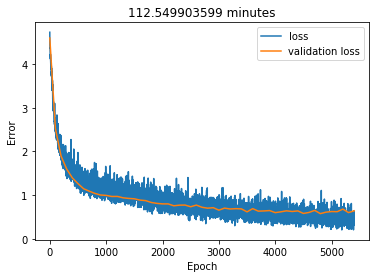

Starting epoch 	5401
Starting epoch 	5402
Starting epoch 	5403
Starting epoch 	5404
Starting epoch 	5405
Starting epoch 	5406
Starting epoch 	5407
Starting epoch 	5408
Starting epoch 	5409
Starting epoch 	5410
Starting epoch 	5411
Starting epoch 	5412
Starting epoch 	5413
Starting epoch 	5414
Starting epoch 	5415
Starting epoch 	5416
Starting epoch 	5417
Starting epoch 	5418
Starting epoch 	5419
Starting epoch 	5420
Starting epoch 	5421
Starting epoch 	5422
Starting epoch 	5423
Starting epoch 	5424
Starting epoch 	5425
Starting epoch 	5426
Starting epoch 	5427
Starting epoch 	5428
Starting epoch 	5429
Starting epoch 	5430
Starting epoch 	5431
Starting epoch 	5432
Starting epoch 	5433
Starting epoch 	5434
Starting epoch 	5435
Starting epoch 	5436
Starting epoch 	5437
Starting epoch 	5438
Starting epoch 	5439
Starting epoch 	5440
Starting epoch 	5441
Starting epoch 	5442
Starting epoch 	5443
Starting epoch 	5444
Starting epoch 	5445
Starting epoch 	5446
Starting epoch 	5447
Starting epoc

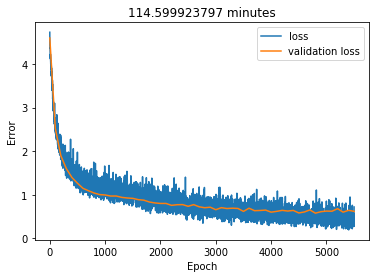

Starting epoch 	5501
Starting epoch 	5502
Starting epoch 	5503
Starting epoch 	5504
Starting epoch 	5505
Starting epoch 	5506
Starting epoch 	5507
Starting epoch 	5508
Starting epoch 	5509
Starting epoch 	5510
Starting epoch 	5511
Starting epoch 	5512
Starting epoch 	5513
Starting epoch 	5514
Starting epoch 	5515
Starting epoch 	5516
Starting epoch 	5517
Starting epoch 	5518
Starting epoch 	5519
Starting epoch 	5520
Starting epoch 	5521
Starting epoch 	5522
Starting epoch 	5523
Starting epoch 	5524
Starting epoch 	5525
Starting epoch 	5526
Starting epoch 	5527
Starting epoch 	5528
Starting epoch 	5529
Starting epoch 	5530
Starting epoch 	5531
Starting epoch 	5532
Starting epoch 	5533
Starting epoch 	5534
Starting epoch 	5535
Starting epoch 	5536
Starting epoch 	5537
Starting epoch 	5538
Starting epoch 	5539
Starting epoch 	5540
Starting epoch 	5541
Starting epoch 	5542
Starting epoch 	5543
Starting epoch 	5544
Starting epoch 	5545
Starting epoch 	5546
Starting epoch 	5547
Starting epoc

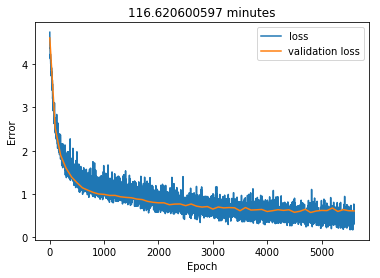

Starting epoch 	5601
Starting epoch 	5602
Starting epoch 	5603
Starting epoch 	5604
Starting epoch 	5605
Starting epoch 	5606
Starting epoch 	5607
Starting epoch 	5608
Starting epoch 	5609
Starting epoch 	5610
Starting epoch 	5611
Starting epoch 	5612
Starting epoch 	5613
Starting epoch 	5614
Starting epoch 	5615
Starting epoch 	5616
Starting epoch 	5617
Starting epoch 	5618
Starting epoch 	5619
Starting epoch 	5620
Starting epoch 	5621
Starting epoch 	5622
Starting epoch 	5623
Starting epoch 	5624
Starting epoch 	5625
Starting epoch 	5626
Starting epoch 	5627
Starting epoch 	5628
Starting epoch 	5629
Starting epoch 	5630
Starting epoch 	5631
Starting epoch 	5632
Starting epoch 	5633
Starting epoch 	5634
Starting epoch 	5635
Starting epoch 	5636
Starting epoch 	5637
Starting epoch 	5638
Starting epoch 	5639
Starting epoch 	5640
Starting epoch 	5641
Starting epoch 	5642
Starting epoch 	5643
Starting epoch 	5644
Starting epoch 	5645
Starting epoch 	5646
Starting epoch 	5647
Starting epoc

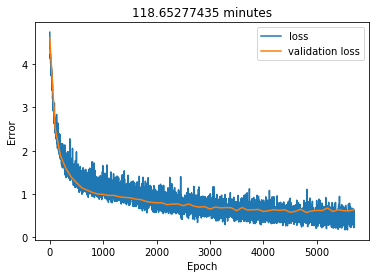

Starting epoch 	5701
Starting epoch 	5702
Starting epoch 	5703
Starting epoch 	5704
Starting epoch 	5705
Starting epoch 	5706
Starting epoch 	5707
Starting epoch 	5708
Starting epoch 	5709
Starting epoch 	5710
Starting epoch 	5711
Starting epoch 	5712
Starting epoch 	5713
Starting epoch 	5714
Starting epoch 	5715
Starting epoch 	5716
Starting epoch 	5717
Starting epoch 	5718
Starting epoch 	5719
Starting epoch 	5720
Starting epoch 	5721
Starting epoch 	5722
Starting epoch 	5723
Starting epoch 	5724
Starting epoch 	5725
Starting epoch 	5726
Starting epoch 	5727
Starting epoch 	5728
Starting epoch 	5729
Starting epoch 	5730
Starting epoch 	5731
Starting epoch 	5732
Starting epoch 	5733
Starting epoch 	5734
Starting epoch 	5735
Starting epoch 	5736
Starting epoch 	5737
Starting epoch 	5738
Starting epoch 	5739
Starting epoch 	5740
Starting epoch 	5741
Starting epoch 	5742
Starting epoch 	5743
Starting epoch 	5744
Starting epoch 	5745
Starting epoch 	5746
Starting epoch 	5747
Starting epoc

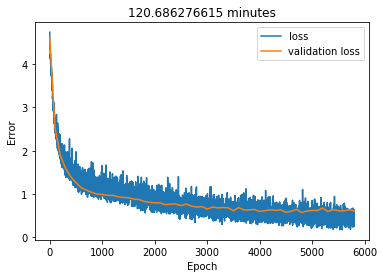

Starting epoch 	5801
Starting epoch 	5802
Starting epoch 	5803
Starting epoch 	5804
Starting epoch 	5805
Starting epoch 	5806
Starting epoch 	5807
Starting epoch 	5808
Starting epoch 	5809
Starting epoch 	5810
Starting epoch 	5811
Starting epoch 	5812
Starting epoch 	5813
Starting epoch 	5814
Starting epoch 	5815
Starting epoch 	5816
Starting epoch 	5817
Starting epoch 	5818
Starting epoch 	5819
Starting epoch 	5820
Starting epoch 	5821
Starting epoch 	5822
Starting epoch 	5823
Starting epoch 	5824
Starting epoch 	5825
Starting epoch 	5826
Starting epoch 	5827
Starting epoch 	5828
Starting epoch 	5829
Starting epoch 	5830
Starting epoch 	5831
Starting epoch 	5832
Starting epoch 	5833
Starting epoch 	5834
Starting epoch 	5835
Starting epoch 	5836
Starting epoch 	5837
Starting epoch 	5838
Starting epoch 	5839
Starting epoch 	5840
Starting epoch 	5841
Starting epoch 	5842
Starting epoch 	5843
Starting epoch 	5844
Starting epoch 	5845
Starting epoch 	5846
Starting epoch 	5847
Starting epoc

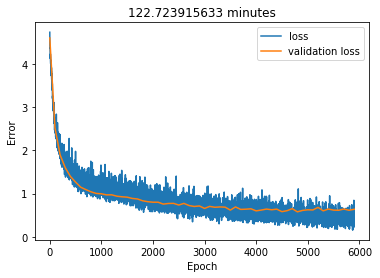

Starting epoch 	5901
Starting epoch 	5902
Starting epoch 	5903
Starting epoch 	5904
Starting epoch 	5905
Starting epoch 	5906
Starting epoch 	5907
Starting epoch 	5908
Starting epoch 	5909
Starting epoch 	5910
Starting epoch 	5911
Starting epoch 	5912
Starting epoch 	5913
Starting epoch 	5914
Starting epoch 	5915
Starting epoch 	5916
Starting epoch 	5917
Starting epoch 	5918
Starting epoch 	5919
Starting epoch 	5920
Starting epoch 	5921
Starting epoch 	5922
Starting epoch 	5923
Starting epoch 	5924
Starting epoch 	5925
Starting epoch 	5926
Starting epoch 	5927
Starting epoch 	5928
Starting epoch 	5929
Starting epoch 	5930
Starting epoch 	5931
Starting epoch 	5932
Starting epoch 	5933
Starting epoch 	5934
Starting epoch 	5935
Starting epoch 	5936
Starting epoch 	5937
Starting epoch 	5938
Starting epoch 	5939
Starting epoch 	5940
Starting epoch 	5941
Starting epoch 	5942
Starting epoch 	5943
Starting epoch 	5944
Starting epoch 	5945
Starting epoch 	5946
Starting epoch 	5947
Starting epoc

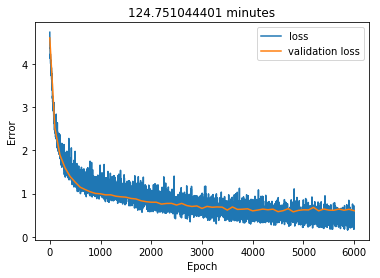

Starting epoch 	6001
Starting epoch 	6002
Starting epoch 	6003
Starting epoch 	6004
Starting epoch 	6005
Starting epoch 	6006
Starting epoch 	6007
Starting epoch 	6008
Starting epoch 	6009
Starting epoch 	6010
Starting epoch 	6011
Starting epoch 	6012
Starting epoch 	6013
Starting epoch 	6014
Starting epoch 	6015
Starting epoch 	6016
Starting epoch 	6017
Starting epoch 	6018
Starting epoch 	6019
Starting epoch 	6020
Starting epoch 	6021
Starting epoch 	6022
Starting epoch 	6023
Starting epoch 	6024
Starting epoch 	6025
Starting epoch 	6026
Starting epoch 	6027
Starting epoch 	6028
Starting epoch 	6029
Starting epoch 	6030
Starting epoch 	6031
Starting epoch 	6032
Starting epoch 	6033
Starting epoch 	6034
Starting epoch 	6035
Starting epoch 	6036
Starting epoch 	6037
Starting epoch 	6038
Starting epoch 	6039
Starting epoch 	6040
Starting epoch 	6041
Starting epoch 	6042
Starting epoch 	6043
Starting epoch 	6044
Starting epoch 	6045
Starting epoch 	6046
Starting epoch 	6047
Starting epoc

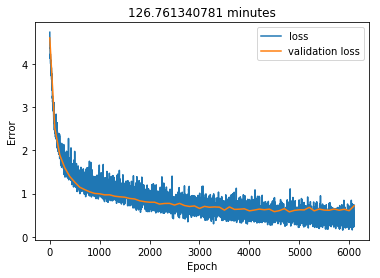

Starting epoch 	6101
Starting epoch 	6102
Starting epoch 	6103
Starting epoch 	6104
Starting epoch 	6105
Starting epoch 	6106
Starting epoch 	6107
Starting epoch 	6108
Starting epoch 	6109
Starting epoch 	6110
Starting epoch 	6111
Starting epoch 	6112
Starting epoch 	6113
Starting epoch 	6114
Starting epoch 	6115
Starting epoch 	6116
Starting epoch 	6117
Starting epoch 	6118
Starting epoch 	6119
Starting epoch 	6120
Starting epoch 	6121
Starting epoch 	6122
Starting epoch 	6123
Starting epoch 	6124
Starting epoch 	6125
Starting epoch 	6126
Starting epoch 	6127
Starting epoch 	6128
Starting epoch 	6129
Starting epoch 	6130
Starting epoch 	6131
Starting epoch 	6132
Starting epoch 	6133
Starting epoch 	6134
Starting epoch 	6135
Starting epoch 	6136
Starting epoch 	6137
Starting epoch 	6138
Starting epoch 	6139
Starting epoch 	6140
Starting epoch 	6141
Starting epoch 	6142
Starting epoch 	6143
Starting epoch 	6144
Starting epoch 	6145
Starting epoch 	6146
Starting epoch 	6147
Starting epoc

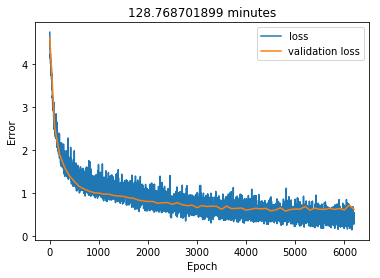

Starting epoch 	6201
Starting epoch 	6202
Starting epoch 	6203
Starting epoch 	6204
Starting epoch 	6205
Starting epoch 	6206
Starting epoch 	6207
Starting epoch 	6208
Starting epoch 	6209
Starting epoch 	6210
Starting epoch 	6211
Starting epoch 	6212
Starting epoch 	6213
Starting epoch 	6214
Starting epoch 	6215
Starting epoch 	6216
Starting epoch 	6217
Starting epoch 	6218
Starting epoch 	6219
Starting epoch 	6220
Starting epoch 	6221
Starting epoch 	6222
Starting epoch 	6223
Starting epoch 	6224
Starting epoch 	6225
Starting epoch 	6226
Starting epoch 	6227
Starting epoch 	6228
Starting epoch 	6229
Starting epoch 	6230
Starting epoch 	6231
Starting epoch 	6232
Starting epoch 	6233
Starting epoch 	6234
Starting epoch 	6235
Starting epoch 	6236
Starting epoch 	6237
Starting epoch 	6238
Starting epoch 	6239
Starting epoch 	6240
Starting epoch 	6241
Starting epoch 	6242
Starting epoch 	6243
Starting epoch 	6244
Starting epoch 	6245
Starting epoch 	6246
Starting epoch 	6247
Starting epoc

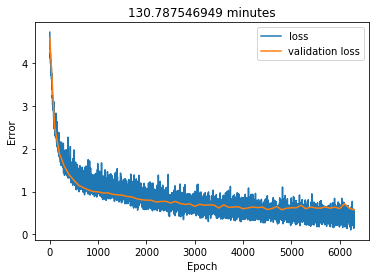

Starting epoch 	6301
Starting epoch 	6302
Starting epoch 	6303
Starting epoch 	6304
Starting epoch 	6305
Starting epoch 	6306
Starting epoch 	6307
Starting epoch 	6308
Starting epoch 	6309
Starting epoch 	6310
Starting epoch 	6311
Starting epoch 	6312
Starting epoch 	6313
Starting epoch 	6314
Starting epoch 	6315
Starting epoch 	6316
Starting epoch 	6317
Starting epoch 	6318
Starting epoch 	6319
Starting epoch 	6320
Starting epoch 	6321
Starting epoch 	6322
Starting epoch 	6323
Starting epoch 	6324
Starting epoch 	6325
Starting epoch 	6326
Starting epoch 	6327
Starting epoch 	6328
Starting epoch 	6329
Starting epoch 	6330
Starting epoch 	6331
Starting epoch 	6332
Starting epoch 	6333
Starting epoch 	6334
Starting epoch 	6335
Starting epoch 	6336
Starting epoch 	6337
Starting epoch 	6338
Starting epoch 	6339
Starting epoch 	6340
Starting epoch 	6341
Starting epoch 	6342
Starting epoch 	6343
Starting epoch 	6344
Starting epoch 	6345
Starting epoch 	6346
Starting epoch 	6347
Starting epoc

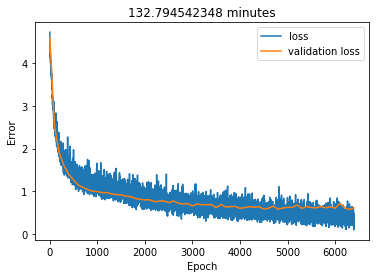

Starting epoch 	6401
Starting epoch 	6402
Starting epoch 	6403
Starting epoch 	6404
Starting epoch 	6405
Starting epoch 	6406
Starting epoch 	6407
Starting epoch 	6408
Starting epoch 	6409
Starting epoch 	6410
Starting epoch 	6411
Starting epoch 	6412
Starting epoch 	6413
Starting epoch 	6414
Starting epoch 	6415
Starting epoch 	6416
Starting epoch 	6417
Starting epoch 	6418
Starting epoch 	6419
Starting epoch 	6420
Starting epoch 	6421
Starting epoch 	6422
Starting epoch 	6423
Starting epoch 	6424
Starting epoch 	6425
Starting epoch 	6426
Starting epoch 	6427
Starting epoch 	6428
Starting epoch 	6429
Starting epoch 	6430
Starting epoch 	6431
Starting epoch 	6432
Starting epoch 	6433
Starting epoch 	6434
Starting epoch 	6435
Starting epoch 	6436
Starting epoch 	6437
Starting epoch 	6438
Starting epoch 	6439
Starting epoch 	6440
Starting epoch 	6441
Starting epoch 	6442
Starting epoch 	6443
Starting epoch 	6444
Starting epoch 	6445
Starting epoch 	6446
Starting epoch 	6447
Starting epoc

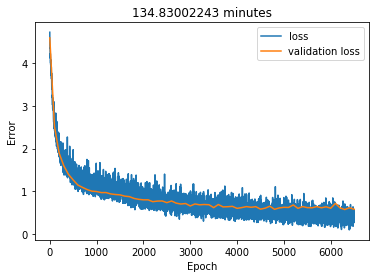

Starting epoch 	6501
Starting epoch 	6502
Starting epoch 	6503
Starting epoch 	6504
Starting epoch 	6505
Starting epoch 	6506
Starting epoch 	6507
Starting epoch 	6508
Starting epoch 	6509
Starting epoch 	6510
Starting epoch 	6511
Starting epoch 	6512
Starting epoch 	6513
Starting epoch 	6514
Starting epoch 	6515
Starting epoch 	6516
Starting epoch 	6517
Starting epoch 	6518
Starting epoch 	6519
Starting epoch 	6520
Starting epoch 	6521
Starting epoch 	6522
Starting epoch 	6523
Starting epoch 	6524
Starting epoch 	6525
Starting epoch 	6526
Starting epoch 	6527
Starting epoch 	6528
Starting epoch 	6529
Starting epoch 	6530
Starting epoch 	6531
Starting epoch 	6532
Starting epoch 	6533
Starting epoch 	6534
Starting epoch 	6535
Starting epoch 	6536
Starting epoch 	6537
Starting epoch 	6538
Starting epoch 	6539
Starting epoch 	6540
Starting epoch 	6541
Starting epoch 	6542
Starting epoch 	6543
Starting epoch 	6544
Starting epoch 	6545
Starting epoch 	6546
Starting epoch 	6547
Starting epoc

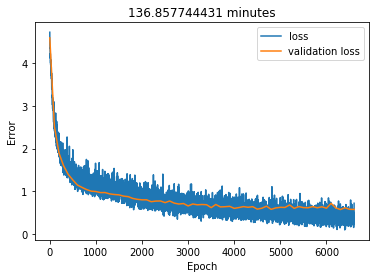

Starting epoch 	6601
Starting epoch 	6602
Starting epoch 	6603
Starting epoch 	6604
Starting epoch 	6605
Starting epoch 	6606
Starting epoch 	6607
Starting epoch 	6608
Starting epoch 	6609
Starting epoch 	6610
Starting epoch 	6611
Starting epoch 	6612
Starting epoch 	6613
Starting epoch 	6614
Starting epoch 	6615
Starting epoch 	6616
Starting epoch 	6617
Starting epoch 	6618
Starting epoch 	6619
Starting epoch 	6620
Starting epoch 	6621
Starting epoch 	6622
Starting epoch 	6623
Starting epoch 	6624
Starting epoch 	6625
Starting epoch 	6626
Starting epoch 	6627
Starting epoch 	6628
Starting epoch 	6629
Starting epoch 	6630
Starting epoch 	6631
Starting epoch 	6632
Starting epoch 	6633
Starting epoch 	6634
Starting epoch 	6635
Starting epoch 	6636
Starting epoch 	6637
Starting epoch 	6638
Starting epoch 	6639
Starting epoch 	6640
Starting epoch 	6641
Starting epoch 	6642
Starting epoch 	6643
Starting epoch 	6644
Starting epoch 	6645
Starting epoch 	6646
Starting epoch 	6647
Starting epoc

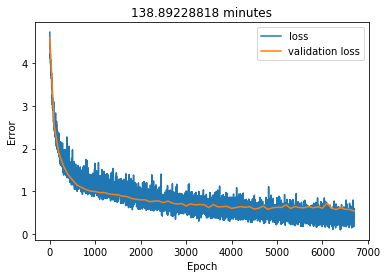

Starting epoch 	6701
Starting epoch 	6702
Starting epoch 	6703
Starting epoch 	6704
Starting epoch 	6705
Starting epoch 	6706
Starting epoch 	6707
Starting epoch 	6708
Starting epoch 	6709
Starting epoch 	6710
Starting epoch 	6711
Starting epoch 	6712
Starting epoch 	6713
Starting epoch 	6714
Starting epoch 	6715
Starting epoch 	6716
Starting epoch 	6717
Starting epoch 	6718
Starting epoch 	6719
Starting epoch 	6720
Starting epoch 	6721
Starting epoch 	6722
Starting epoch 	6723
Starting epoch 	6724
Starting epoch 	6725
Starting epoch 	6726
Starting epoch 	6727
Starting epoch 	6728
Starting epoch 	6729
Starting epoch 	6730
Starting epoch 	6731
Starting epoch 	6732
Starting epoch 	6733
Starting epoch 	6734
Starting epoch 	6735
Starting epoch 	6736
Starting epoch 	6737
Starting epoch 	6738
Starting epoch 	6739
Starting epoch 	6740
Starting epoch 	6741
Starting epoch 	6742
Starting epoch 	6743
Starting epoch 	6744
Starting epoch 	6745
Starting epoch 	6746
Starting epoch 	6747
Starting epoc

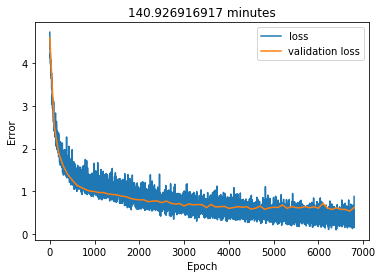

Starting epoch 	6801
Starting epoch 	6802
Starting epoch 	6803
Starting epoch 	6804
Starting epoch 	6805
Starting epoch 	6806
Starting epoch 	6807
Starting epoch 	6808
Starting epoch 	6809
Starting epoch 	6810
Starting epoch 	6811
Starting epoch 	6812
Starting epoch 	6813
Starting epoch 	6814
Starting epoch 	6815
Starting epoch 	6816
Starting epoch 	6817
Starting epoch 	6818
Starting epoch 	6819
Starting epoch 	6820
Starting epoch 	6821
Starting epoch 	6822
Starting epoch 	6823
Starting epoch 	6824
Starting epoch 	6825
Starting epoch 	6826
Starting epoch 	6827
Starting epoch 	6828
Starting epoch 	6829
Starting epoch 	6830
Starting epoch 	6831
Starting epoch 	6832
Starting epoch 	6833
Starting epoch 	6834
Starting epoch 	6835
Starting epoch 	6836
Starting epoch 	6837
Starting epoch 	6838
Starting epoch 	6839
Starting epoch 	6840
Starting epoch 	6841
Starting epoch 	6842
Starting epoch 	6843
Starting epoch 	6844
Starting epoch 	6845
Starting epoch 	6846
Starting epoch 	6847
Starting epoc

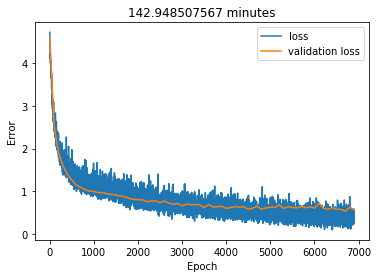

Starting epoch 	6901
Starting epoch 	6902
Starting epoch 	6903
Starting epoch 	6904
Starting epoch 	6905
Starting epoch 	6906
Starting epoch 	6907
Starting epoch 	6908
Starting epoch 	6909
Starting epoch 	6910
Starting epoch 	6911
Starting epoch 	6912
Starting epoch 	6913
Starting epoch 	6914
Starting epoch 	6915
Starting epoch 	6916
Starting epoch 	6917
Starting epoch 	6918
Starting epoch 	6919
Starting epoch 	6920
Starting epoch 	6921
Starting epoch 	6922
Starting epoch 	6923
Starting epoch 	6924
Starting epoch 	6925
Starting epoch 	6926
Starting epoch 	6927
Starting epoch 	6928
Starting epoch 	6929
Starting epoch 	6930
Starting epoch 	6931
Starting epoch 	6932
Starting epoch 	6933
Starting epoch 	6934
Starting epoch 	6935
Starting epoch 	6936
Starting epoch 	6937
Starting epoch 	6938
Starting epoch 	6939
Starting epoch 	6940
Starting epoch 	6941
Starting epoch 	6942
Starting epoch 	6943
Starting epoch 	6944
Starting epoch 	6945
Starting epoch 	6946
Starting epoch 	6947
Starting epoc

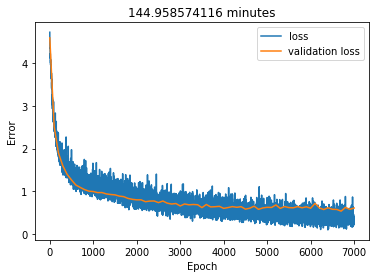

Starting epoch 	7001
Starting epoch 	7002
Starting epoch 	7003
Starting epoch 	7004
Starting epoch 	7005
Starting epoch 	7006
Starting epoch 	7007
Starting epoch 	7008
Starting epoch 	7009
Starting epoch 	7010
Starting epoch 	7011
Starting epoch 	7012
Starting epoch 	7013
Starting epoch 	7014
Starting epoch 	7015
Starting epoch 	7016
Starting epoch 	7017
Starting epoch 	7018
Starting epoch 	7019
Starting epoch 	7020
Starting epoch 	7021
Starting epoch 	7022
Starting epoch 	7023
Starting epoch 	7024
Starting epoch 	7025
Starting epoch 	7026
Starting epoch 	7027
Starting epoch 	7028
Starting epoch 	7029
Starting epoch 	7030
Starting epoch 	7031
Starting epoch 	7032
Starting epoch 	7033
Starting epoch 	7034
Starting epoch 	7035
Starting epoch 	7036
Starting epoch 	7037
Starting epoch 	7038
Starting epoch 	7039
Starting epoch 	7040
Starting epoch 	7041
Starting epoch 	7042
Starting epoch 	7043
Starting epoch 	7044
Starting epoch 	7045
Starting epoch 	7046
Starting epoch 	7047
Starting epoc

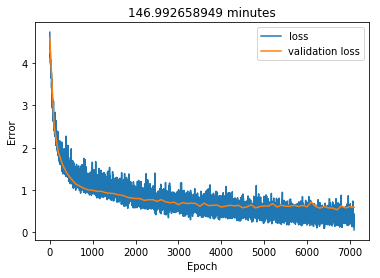

Starting epoch 	7101
Starting epoch 	7102
Starting epoch 	7103
Starting epoch 	7104
Starting epoch 	7105
Starting epoch 	7106
Starting epoch 	7107
Starting epoch 	7108
Starting epoch 	7109
Starting epoch 	7110
Starting epoch 	7111
Starting epoch 	7112
Starting epoch 	7113
Starting epoch 	7114
Starting epoch 	7115
Starting epoch 	7116
Starting epoch 	7117
Starting epoch 	7118
Starting epoch 	7119
Starting epoch 	7120
Starting epoch 	7121
Starting epoch 	7122
Starting epoch 	7123
Starting epoch 	7124
Starting epoch 	7125
Starting epoch 	7126
Starting epoch 	7127
Starting epoch 	7128
Starting epoch 	7129
Starting epoch 	7130
Starting epoch 	7131
Starting epoch 	7132
Starting epoch 	7133
Starting epoch 	7134
Starting epoch 	7135
Starting epoch 	7136
Starting epoch 	7137
Starting epoch 	7138
Starting epoch 	7139
Starting epoch 	7140
Starting epoch 	7141
Starting epoch 	7142
Starting epoch 	7143
Starting epoch 	7144
Starting epoch 	7145
Starting epoch 	7146
Starting epoch 	7147
Starting epoc

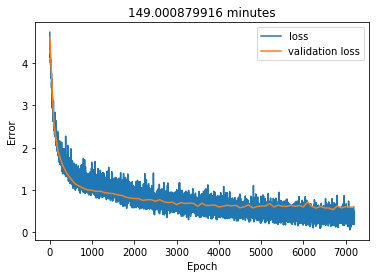

Starting epoch 	7201
Starting epoch 	7202
Starting epoch 	7203
Starting epoch 	7204
Starting epoch 	7205
Starting epoch 	7206
Starting epoch 	7207
Starting epoch 	7208
Starting epoch 	7209
Starting epoch 	7210
Starting epoch 	7211
Starting epoch 	7212
Starting epoch 	7213
Starting epoch 	7214
Starting epoch 	7215
Starting epoch 	7216
Starting epoch 	7217
Starting epoch 	7218
Starting epoch 	7219
Starting epoch 	7220
Starting epoch 	7221
Starting epoch 	7222
Starting epoch 	7223
Starting epoch 	7224
Starting epoch 	7225
Starting epoch 	7226
Starting epoch 	7227
Starting epoch 	7228
Starting epoch 	7229
Starting epoch 	7230
Starting epoch 	7231
Starting epoch 	7232
Starting epoch 	7233
Starting epoch 	7234
Starting epoch 	7235
Starting epoch 	7236
Starting epoch 	7237
Starting epoch 	7238
Starting epoch 	7239
Starting epoch 	7240
Starting epoch 	7241
Starting epoch 	7242
Starting epoch 	7243
Starting epoch 	7244
Starting epoch 	7245
Starting epoch 	7246
Starting epoch 	7247
Starting epoc

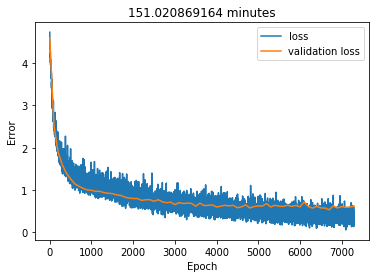

Starting epoch 	7301
Starting epoch 	7302
Starting epoch 	7303
Starting epoch 	7304
Starting epoch 	7305
Starting epoch 	7306
Starting epoch 	7307
Starting epoch 	7308
Starting epoch 	7309
Starting epoch 	7310
Starting epoch 	7311
Starting epoch 	7312
Starting epoch 	7313
Starting epoch 	7314
Starting epoch 	7315
Starting epoch 	7316
Starting epoch 	7317
Starting epoch 	7318
Starting epoch 	7319
Starting epoch 	7320
Starting epoch 	7321
Starting epoch 	7322
Starting epoch 	7323
Starting epoch 	7324
Starting epoch 	7325
Starting epoch 	7326
Starting epoch 	7327
Starting epoch 	7328
Starting epoch 	7329
Starting epoch 	7330
Starting epoch 	7331
Starting epoch 	7332
Starting epoch 	7333
Starting epoch 	7334
Starting epoch 	7335
Starting epoch 	7336
Starting epoch 	7337
Starting epoch 	7338
Starting epoch 	7339
Starting epoch 	7340
Starting epoch 	7341
Starting epoch 	7342
Starting epoch 	7343
Starting epoch 	7344
Starting epoch 	7345
Starting epoch 	7346
Starting epoch 	7347
Starting epoc

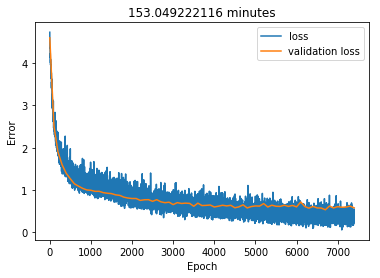

Starting epoch 	7401
Starting epoch 	7402
Starting epoch 	7403
Starting epoch 	7404
Starting epoch 	7405
Starting epoch 	7406
Starting epoch 	7407
Starting epoch 	7408
Starting epoch 	7409
Starting epoch 	7410
Starting epoch 	7411
Starting epoch 	7412
Starting epoch 	7413
Starting epoch 	7414
Starting epoch 	7415
Starting epoch 	7416
Starting epoch 	7417
Starting epoch 	7418
Starting epoch 	7419
Starting epoch 	7420
Starting epoch 	7421
Starting epoch 	7422
Starting epoch 	7423
Starting epoch 	7424
Starting epoch 	7425
Starting epoch 	7426
Starting epoch 	7427
Starting epoch 	7428
Starting epoch 	7429
Starting epoch 	7430
Starting epoch 	7431
Starting epoch 	7432
Starting epoch 	7433
Starting epoch 	7434
Starting epoch 	7435
Starting epoch 	7436
Starting epoch 	7437
Starting epoch 	7438
Starting epoch 	7439
Starting epoch 	7440
Starting epoch 	7441
Starting epoch 	7442
Starting epoch 	7443
Starting epoch 	7444
Starting epoch 	7445
Starting epoch 	7446
Starting epoch 	7447
Starting epoc

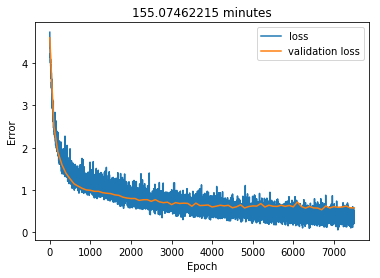

Starting epoch 	7501
Starting epoch 	7502
Starting epoch 	7503
Starting epoch 	7504
Starting epoch 	7505
Starting epoch 	7506
Starting epoch 	7507
Starting epoch 	7508
Starting epoch 	7509
Starting epoch 	7510
Starting epoch 	7511
Starting epoch 	7512
Starting epoch 	7513
Starting epoch 	7514
Starting epoch 	7515
Starting epoch 	7516
Starting epoch 	7517
Starting epoch 	7518
Starting epoch 	7519
Starting epoch 	7520
Starting epoch 	7521
Starting epoch 	7522
Starting epoch 	7523
Starting epoch 	7524
Starting epoch 	7525
Starting epoch 	7526
Starting epoch 	7527
Starting epoch 	7528
Starting epoch 	7529
Starting epoch 	7530
Starting epoch 	7531
Starting epoch 	7532
Starting epoch 	7533
Starting epoch 	7534
Starting epoch 	7535
Starting epoch 	7536
Starting epoch 	7537
Starting epoch 	7538
Starting epoch 	7539
Starting epoch 	7540
Starting epoch 	7541
Starting epoch 	7542
Starting epoch 	7543
Starting epoch 	7544
Starting epoch 	7545
Starting epoch 	7546
Starting epoch 	7547
Starting epoc

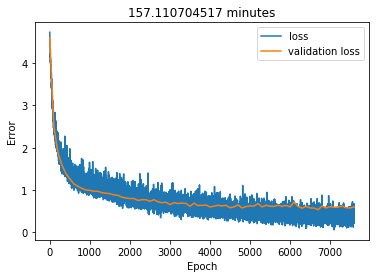

Starting epoch 	7601
Starting epoch 	7602
Starting epoch 	7603
Starting epoch 	7604
Starting epoch 	7605
Starting epoch 	7606
Starting epoch 	7607
Starting epoch 	7608
Starting epoch 	7609
Starting epoch 	7610
Starting epoch 	7611
Starting epoch 	7612
Starting epoch 	7613
Starting epoch 	7614
Starting epoch 	7615
Starting epoch 	7616
Starting epoch 	7617
Starting epoch 	7618
Starting epoch 	7619
Starting epoch 	7620
Starting epoch 	7621
Starting epoch 	7622
Starting epoch 	7623
Starting epoch 	7624
Starting epoch 	7625
Starting epoch 	7626
Starting epoch 	7627
Starting epoch 	7628
Starting epoch 	7629
Starting epoch 	7630
Starting epoch 	7631
Starting epoch 	7632
Starting epoch 	7633
Starting epoch 	7634
Starting epoch 	7635
Starting epoch 	7636
Starting epoch 	7637
Starting epoch 	7638
Starting epoch 	7639
Starting epoch 	7640
Starting epoch 	7641
Starting epoch 	7642
Starting epoch 	7643
Starting epoch 	7644
Starting epoch 	7645
Starting epoch 	7646
Starting epoch 	7647
Starting epoc

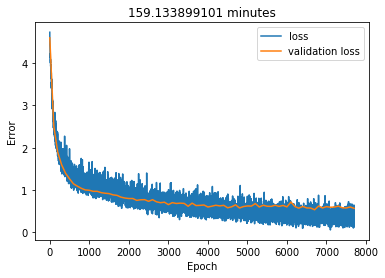

Starting epoch 	7701
Starting epoch 	7702
Starting epoch 	7703
Starting epoch 	7704
Starting epoch 	7705
Starting epoch 	7706
Starting epoch 	7707
Starting epoch 	7708
Starting epoch 	7709
Starting epoch 	7710
Starting epoch 	7711
Starting epoch 	7712
Starting epoch 	7713
Starting epoch 	7714
Starting epoch 	7715
Starting epoch 	7716
Starting epoch 	7717
Starting epoch 	7718
Starting epoch 	7719
Starting epoch 	7720
Starting epoch 	7721
Starting epoch 	7722
Starting epoch 	7723
Starting epoch 	7724
Starting epoch 	7725
Starting epoch 	7726
Starting epoch 	7727
Starting epoch 	7728
Starting epoch 	7729
Starting epoch 	7730
Starting epoch 	7731
Starting epoch 	7732
Starting epoch 	7733
Starting epoch 	7734
Starting epoch 	7735
Starting epoch 	7736
Starting epoch 	7737
Starting epoch 	7738
Starting epoch 	7739
Starting epoch 	7740
Starting epoch 	7741
Starting epoch 	7742
Starting epoch 	7743
Starting epoch 	7744
Starting epoch 	7745
Starting epoch 	7746
Starting epoch 	7747
Starting epoc

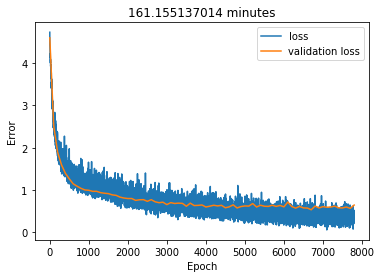

Starting epoch 	7801
Starting epoch 	7802
Starting epoch 	7803
Starting epoch 	7804
Starting epoch 	7805
Starting epoch 	7806
Starting epoch 	7807
Starting epoch 	7808
Starting epoch 	7809
Starting epoch 	7810
Starting epoch 	7811
Starting epoch 	7812
Starting epoch 	7813
Starting epoch 	7814
Starting epoch 	7815
Starting epoch 	7816
Starting epoch 	7817
Starting epoch 	7818
Starting epoch 	7819
Starting epoch 	7820
Starting epoch 	7821
Starting epoch 	7822
Starting epoch 	7823
Starting epoch 	7824
Starting epoch 	7825
Starting epoch 	7826
Starting epoch 	7827
Starting epoch 	7828
Starting epoch 	7829
Starting epoch 	7830
Starting epoch 	7831
Starting epoch 	7832
Starting epoch 	7833
Starting epoch 	7834
Starting epoch 	7835
Starting epoch 	7836
Starting epoch 	7837
Starting epoch 	7838
Starting epoch 	7839
Starting epoch 	7840
Starting epoch 	7841
Starting epoch 	7842
Starting epoch 	7843
Starting epoch 	7844
Starting epoch 	7845
Starting epoch 	7846
Starting epoch 	7847
Starting epoc

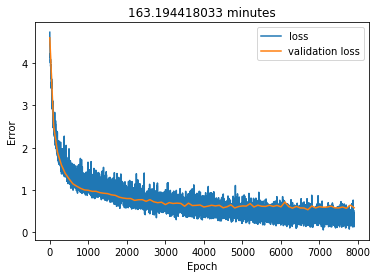

Starting epoch 	7901
Starting epoch 	7902
Starting epoch 	7903
Starting epoch 	7904
Starting epoch 	7905
Starting epoch 	7906
Starting epoch 	7907
Starting epoch 	7908
Starting epoch 	7909
Starting epoch 	7910
Starting epoch 	7911
Starting epoch 	7912
Starting epoch 	7913
Starting epoch 	7914
Starting epoch 	7915
Starting epoch 	7916
Starting epoch 	7917
Starting epoch 	7918
Starting epoch 	7919
Starting epoch 	7920
Starting epoch 	7921
Starting epoch 	7922
Starting epoch 	7923
Starting epoch 	7924
Starting epoch 	7925
Starting epoch 	7926
Starting epoch 	7927
Starting epoch 	7928
Starting epoch 	7929
Starting epoch 	7930
Starting epoch 	7931
Starting epoch 	7932
Starting epoch 	7933
Starting epoch 	7934
Starting epoch 	7935
Starting epoch 	7936
Starting epoch 	7937
Starting epoch 	7938
Starting epoch 	7939
Starting epoch 	7940
Starting epoch 	7941
Starting epoch 	7942
Starting epoch 	7943
Starting epoch 	7944
Starting epoch 	7945
Starting epoch 	7946
Starting epoch 	7947
Starting epoc

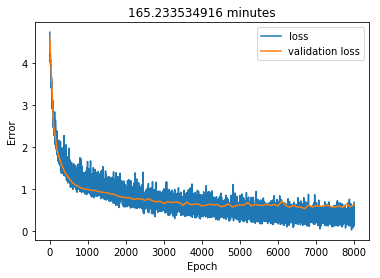

Starting epoch 	8001
Starting epoch 	8002
Starting epoch 	8003
Starting epoch 	8004
Starting epoch 	8005
Starting epoch 	8006
Starting epoch 	8007
Starting epoch 	8008
Starting epoch 	8009
Starting epoch 	8010
Starting epoch 	8011
Starting epoch 	8012
Starting epoch 	8013
Starting epoch 	8014
Starting epoch 	8015
Starting epoch 	8016
Starting epoch 	8017
Starting epoch 	8018
Starting epoch 	8019
Starting epoch 	8020
Starting epoch 	8021
Starting epoch 	8022
Starting epoch 	8023
Starting epoch 	8024
Starting epoch 	8025
Starting epoch 	8026
Starting epoch 	8027
Starting epoch 	8028
Starting epoch 	8029
Starting epoch 	8030
Starting epoch 	8031
Starting epoch 	8032
Starting epoch 	8033
Starting epoch 	8034
Starting epoch 	8035
Starting epoch 	8036
Starting epoch 	8037
Starting epoch 	8038
Starting epoch 	8039
Starting epoch 	8040
Starting epoch 	8041
Starting epoch 	8042
Starting epoch 	8043
Starting epoch 	8044
Starting epoch 	8045
Starting epoch 	8046
Starting epoch 	8047
Starting epoc

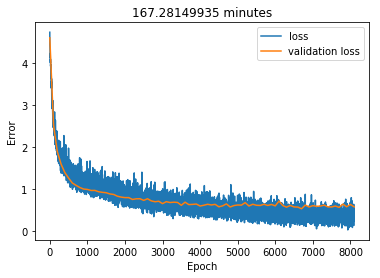

Starting epoch 	8101
Starting epoch 	8102
Starting epoch 	8103
Starting epoch 	8104
Starting epoch 	8105
Starting epoch 	8106
Starting epoch 	8107
Starting epoch 	8108
Starting epoch 	8109
Starting epoch 	8110
Starting epoch 	8111
Starting epoch 	8112
Starting epoch 	8113
Starting epoch 	8114
Starting epoch 	8115
Starting epoch 	8116
Starting epoch 	8117
Starting epoch 	8118
Starting epoch 	8119
Starting epoch 	8120
Starting epoch 	8121
Starting epoch 	8122
Starting epoch 	8123
Starting epoch 	8124
Starting epoch 	8125
Starting epoch 	8126
Starting epoch 	8127
Starting epoch 	8128
Starting epoch 	8129
Starting epoch 	8130
Starting epoch 	8131
Starting epoch 	8132
Starting epoch 	8133
Starting epoch 	8134
Starting epoch 	8135
Starting epoch 	8136
Starting epoch 	8137
Starting epoch 	8138
Starting epoch 	8139
Starting epoch 	8140
Starting epoch 	8141
Starting epoch 	8142
Starting epoch 	8143
Starting epoch 	8144
Starting epoch 	8145
Starting epoch 	8146
Starting epoch 	8147
Starting epoc

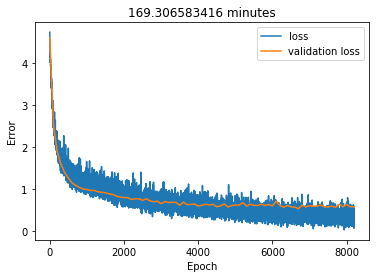

Starting epoch 	8201
Starting epoch 	8202
Starting epoch 	8203
Starting epoch 	8204
Starting epoch 	8205
Starting epoch 	8206
Starting epoch 	8207
Starting epoch 	8208
Starting epoch 	8209
Starting epoch 	8210
Starting epoch 	8211
Starting epoch 	8212
Starting epoch 	8213
Starting epoch 	8214
Starting epoch 	8215
Starting epoch 	8216
Starting epoch 	8217
Starting epoch 	8218
Starting epoch 	8219
Starting epoch 	8220
Starting epoch 	8221
Starting epoch 	8222
Starting epoch 	8223
Starting epoch 	8224
Starting epoch 	8225
Starting epoch 	8226
Starting epoch 	8227
Starting epoch 	8228
Starting epoch 	8229
Starting epoch 	8230
Starting epoch 	8231
Starting epoch 	8232
Starting epoch 	8233
Starting epoch 	8234
Starting epoch 	8235
Starting epoch 	8236
Starting epoch 	8237
Starting epoch 	8238
Starting epoch 	8239
Starting epoch 	8240
Starting epoch 	8241
Starting epoch 	8242
Starting epoch 	8243
Starting epoch 	8244
Starting epoch 	8245
Starting epoch 	8246
Starting epoch 	8247
Starting epoc

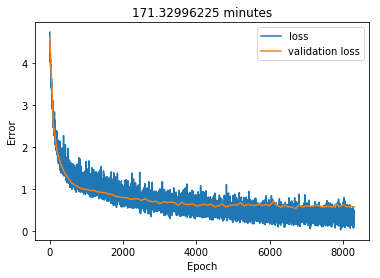

Starting epoch 	8301
Starting epoch 	8302
Starting epoch 	8303
Starting epoch 	8304
Starting epoch 	8305
Starting epoch 	8306
Starting epoch 	8307
Starting epoch 	8308
Starting epoch 	8309
Starting epoch 	8310
Starting epoch 	8311
Starting epoch 	8312
Starting epoch 	8313
Starting epoch 	8314
Starting epoch 	8315
Starting epoch 	8316
Starting epoch 	8317
Starting epoch 	8318
Starting epoch 	8319
Starting epoch 	8320
Starting epoch 	8321
Starting epoch 	8322
Starting epoch 	8323
Starting epoch 	8324
Starting epoch 	8325
Starting epoch 	8326
Starting epoch 	8327
Starting epoch 	8328
Starting epoch 	8329
Starting epoch 	8330
Starting epoch 	8331
Starting epoch 	8332
Starting epoch 	8333
Starting epoch 	8334
Starting epoch 	8335
Starting epoch 	8336
Starting epoch 	8337
Starting epoch 	8338
Starting epoch 	8339
Starting epoch 	8340
Starting epoch 	8341
Starting epoch 	8342
Starting epoch 	8343
Starting epoch 	8344
Starting epoch 	8345
Starting epoch 	8346
Starting epoch 	8347
Starting epoc

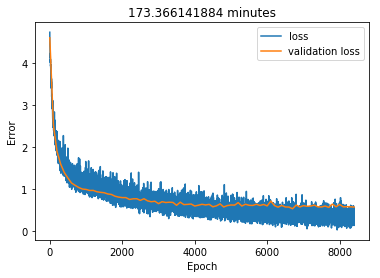

Starting epoch 	8401
Starting epoch 	8402
Starting epoch 	8403
Starting epoch 	8404
Starting epoch 	8405
Starting epoch 	8406
Starting epoch 	8407
Starting epoch 	8408
Starting epoch 	8409
Starting epoch 	8410
Starting epoch 	8411
Starting epoch 	8412
Starting epoch 	8413
Starting epoch 	8414
Starting epoch 	8415
Starting epoch 	8416
Starting epoch 	8417
Starting epoch 	8418
Starting epoch 	8419
Starting epoch 	8420
Starting epoch 	8421
Starting epoch 	8422
Starting epoch 	8423
Starting epoch 	8424
Starting epoch 	8425
Starting epoch 	8426
Starting epoch 	8427
Starting epoch 	8428
Starting epoch 	8429
Starting epoch 	8430
Starting epoch 	8431
Starting epoch 	8432
Starting epoch 	8433
Starting epoch 	8434
Starting epoch 	8435
Starting epoch 	8436
Starting epoch 	8437
Starting epoch 	8438
Starting epoch 	8439
Starting epoch 	8440
Starting epoch 	8441
Starting epoch 	8442
Starting epoch 	8443
Starting epoch 	8444
Starting epoch 	8445
Starting epoch 	8446
Starting epoch 	8447
Starting epoc

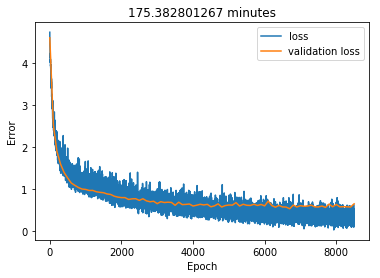

Starting epoch 	8501
Starting epoch 	8502
Starting epoch 	8503
Starting epoch 	8504
Starting epoch 	8505
Starting epoch 	8506
Starting epoch 	8507
Starting epoch 	8508
Starting epoch 	8509
Starting epoch 	8510
Starting epoch 	8511
Starting epoch 	8512
Starting epoch 	8513
Starting epoch 	8514
Starting epoch 	8515
Starting epoch 	8516
Starting epoch 	8517
Starting epoch 	8518
Starting epoch 	8519
Starting epoch 	8520
Starting epoch 	8521
Starting epoch 	8522
Starting epoch 	8523
Starting epoch 	8524
Starting epoch 	8525
Starting epoch 	8526
Starting epoch 	8527
Starting epoch 	8528
Starting epoch 	8529
Starting epoch 	8530
Starting epoch 	8531
Starting epoch 	8532
Starting epoch 	8533
Starting epoch 	8534
Starting epoch 	8535
Starting epoch 	8536
Starting epoch 	8537
Starting epoch 	8538
Starting epoch 	8539
Starting epoch 	8540
Starting epoch 	8541
Starting epoch 	8542
Starting epoch 	8543
Starting epoch 	8544
Starting epoch 	8545
Starting epoch 	8546
Starting epoch 	8547
Starting epoc

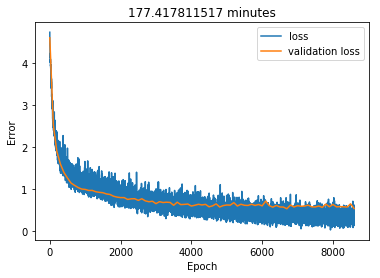

Starting epoch 	8601
Starting epoch 	8602
Starting epoch 	8603
Starting epoch 	8604
Starting epoch 	8605
Starting epoch 	8606
Starting epoch 	8607
Starting epoch 	8608
Starting epoch 	8609
Starting epoch 	8610
Starting epoch 	8611
Starting epoch 	8612
Starting epoch 	8613
Starting epoch 	8614
Starting epoch 	8615
Starting epoch 	8616
Starting epoch 	8617
Starting epoch 	8618
Starting epoch 	8619
Starting epoch 	8620
Starting epoch 	8621
Starting epoch 	8622
Starting epoch 	8623
Starting epoch 	8624
Starting epoch 	8625
Starting epoch 	8626
Starting epoch 	8627
Starting epoch 	8628
Starting epoch 	8629
Starting epoch 	8630
Starting epoch 	8631
Starting epoch 	8632
Starting epoch 	8633
Starting epoch 	8634
Starting epoch 	8635
Starting epoch 	8636
Starting epoch 	8637
Starting epoch 	8638
Starting epoch 	8639
Starting epoch 	8640
Starting epoch 	8641
Starting epoch 	8642
Starting epoch 	8643
Starting epoch 	8644
Starting epoch 	8645
Starting epoch 	8646
Starting epoch 	8647
Starting epoc

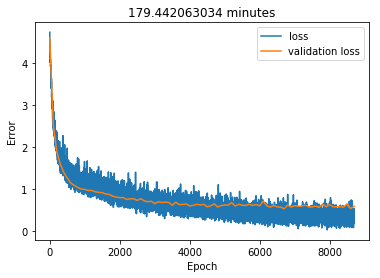

Starting epoch 	8701
Starting epoch 	8702
Starting epoch 	8703
Starting epoch 	8704
Starting epoch 	8705
Starting epoch 	8706
Starting epoch 	8707
Starting epoch 	8708
Starting epoch 	8709
Starting epoch 	8710
Starting epoch 	8711
Starting epoch 	8712
Starting epoch 	8713
Starting epoch 	8714
Starting epoch 	8715
Starting epoch 	8716
Starting epoch 	8717
Starting epoch 	8718
Starting epoch 	8719
Starting epoch 	8720
Starting epoch 	8721
Starting epoch 	8722
Starting epoch 	8723
Starting epoch 	8724
Starting epoch 	8725
Starting epoch 	8726
Starting epoch 	8727
Starting epoch 	8728
Starting epoch 	8729
Starting epoch 	8730
Starting epoch 	8731
Starting epoch 	8732
Starting epoch 	8733
Starting epoch 	8734
Starting epoch 	8735
Starting epoch 	8736
Starting epoch 	8737
Starting epoch 	8738
Starting epoch 	8739
Starting epoch 	8740
Starting epoch 	8741
Starting epoch 	8742
Starting epoch 	8743
Starting epoch 	8744
Starting epoch 	8745
Starting epoch 	8746
Starting epoch 	8747
Starting epoc

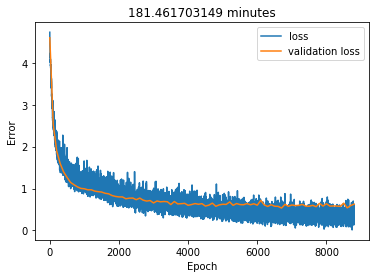

Starting epoch 	8801
Starting epoch 	8802
Starting epoch 	8803
Starting epoch 	8804
Starting epoch 	8805
Starting epoch 	8806
Starting epoch 	8807
Starting epoch 	8808
Starting epoch 	8809
Starting epoch 	8810
Starting epoch 	8811
Starting epoch 	8812
Starting epoch 	8813
Starting epoch 	8814
Starting epoch 	8815
Starting epoch 	8816
Starting epoch 	8817
Starting epoch 	8818
Starting epoch 	8819
Starting epoch 	8820
Starting epoch 	8821
Starting epoch 	8822
Starting epoch 	8823
Starting epoch 	8824
Starting epoch 	8825
Starting epoch 	8826
Starting epoch 	8827
Starting epoch 	8828
Starting epoch 	8829
Starting epoch 	8830
Starting epoch 	8831
Starting epoch 	8832
Starting epoch 	8833
Starting epoch 	8834
Starting epoch 	8835
Starting epoch 	8836
Starting epoch 	8837
Starting epoch 	8838
Starting epoch 	8839
Starting epoch 	8840
Starting epoch 	8841
Starting epoch 	8842
Starting epoch 	8843
Starting epoch 	8844
Starting epoch 	8845
Starting epoch 	8846
Starting epoch 	8847
Starting epoc

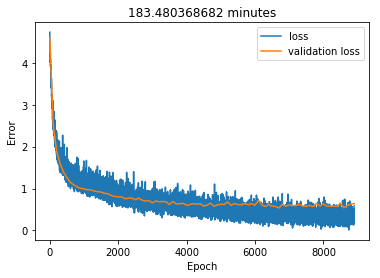

Starting epoch 	8901
Starting epoch 	8902
Starting epoch 	8903
Starting epoch 	8904
Starting epoch 	8905
Starting epoch 	8906
Starting epoch 	8907
Starting epoch 	8908
Starting epoch 	8909
Starting epoch 	8910
Starting epoch 	8911
Starting epoch 	8912
Starting epoch 	8913
Starting epoch 	8914
Starting epoch 	8915
Starting epoch 	8916
Starting epoch 	8917
Starting epoch 	8918
Starting epoch 	8919
Starting epoch 	8920
Starting epoch 	8921
Starting epoch 	8922
Starting epoch 	8923
Starting epoch 	8924
Starting epoch 	8925
Starting epoch 	8926
Starting epoch 	8927
Starting epoch 	8928
Starting epoch 	8929
Starting epoch 	8930
Starting epoch 	8931
Starting epoch 	8932
Starting epoch 	8933
Starting epoch 	8934
Starting epoch 	8935
Starting epoch 	8936
Starting epoch 	8937
Starting epoch 	8938
Starting epoch 	8939
Starting epoch 	8940
Starting epoch 	8941
Starting epoch 	8942
Starting epoch 	8943
Starting epoch 	8944
Starting epoch 	8945
Starting epoch 	8946
Starting epoch 	8947
Starting epoc

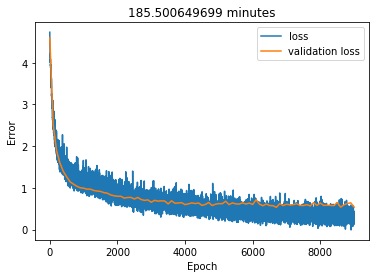

Starting epoch 	9001
Starting epoch 	9002
Starting epoch 	9003
Starting epoch 	9004
Starting epoch 	9005
Starting epoch 	9006
Starting epoch 	9007
Starting epoch 	9008
Starting epoch 	9009
Starting epoch 	9010
Starting epoch 	9011
Starting epoch 	9012
Starting epoch 	9013
Starting epoch 	9014
Starting epoch 	9015
Starting epoch 	9016
Starting epoch 	9017
Starting epoch 	9018
Starting epoch 	9019
Starting epoch 	9020
Starting epoch 	9021
Starting epoch 	9022
Starting epoch 	9023
Starting epoch 	9024
Starting epoch 	9025
Starting epoch 	9026
Starting epoch 	9027
Starting epoch 	9028
Starting epoch 	9029
Starting epoch 	9030
Starting epoch 	9031
Starting epoch 	9032
Starting epoch 	9033
Starting epoch 	9034
Starting epoch 	9035
Starting epoch 	9036
Starting epoch 	9037
Starting epoch 	9038
Starting epoch 	9039
Starting epoch 	9040
Starting epoch 	9041
Starting epoch 	9042
Starting epoch 	9043
Starting epoch 	9044
Starting epoch 	9045
Starting epoch 	9046
Starting epoch 	9047
Starting epoc

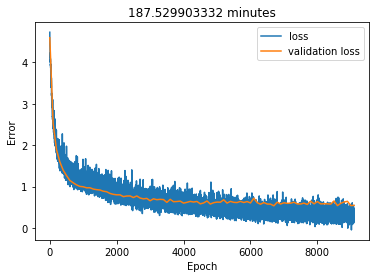

Starting epoch 	9101
Starting epoch 	9102
Starting epoch 	9103
Starting epoch 	9104
Starting epoch 	9105
Starting epoch 	9106
Starting epoch 	9107
Starting epoch 	9108
Starting epoch 	9109
Starting epoch 	9110
Starting epoch 	9111
Starting epoch 	9112
Starting epoch 	9113
Starting epoch 	9114
Starting epoch 	9115
Starting epoch 	9116
Starting epoch 	9117
Starting epoch 	9118
Starting epoch 	9119
Starting epoch 	9120
Starting epoch 	9121
Starting epoch 	9122
Starting epoch 	9123
Starting epoch 	9124
Starting epoch 	9125
Starting epoch 	9126
Starting epoch 	9127
Starting epoch 	9128
Starting epoch 	9129
Starting epoch 	9130
Starting epoch 	9131
Starting epoch 	9132
Starting epoch 	9133
Starting epoch 	9134
Starting epoch 	9135
Starting epoch 	9136
Starting epoch 	9137
Starting epoch 	9138
Starting epoch 	9139
Starting epoch 	9140
Starting epoch 	9141
Starting epoch 	9142
Starting epoch 	9143
Starting epoch 	9144
Starting epoch 	9145
Starting epoch 	9146
Starting epoch 	9147
Starting epoc

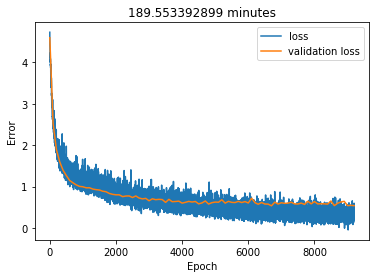

Starting epoch 	9201
Starting epoch 	9202
Starting epoch 	9203
Starting epoch 	9204
Starting epoch 	9205
Starting epoch 	9206
Starting epoch 	9207
Starting epoch 	9208
Starting epoch 	9209
Starting epoch 	9210
Starting epoch 	9211
Starting epoch 	9212
Starting epoch 	9213
Starting epoch 	9214
Starting epoch 	9215
Starting epoch 	9216
Starting epoch 	9217
Starting epoch 	9218
Starting epoch 	9219
Starting epoch 	9220
Starting epoch 	9221
Starting epoch 	9222
Starting epoch 	9223
Starting epoch 	9224
Starting epoch 	9225
Starting epoch 	9226
Starting epoch 	9227
Starting epoch 	9228
Starting epoch 	9229
Starting epoch 	9230
Starting epoch 	9231
Starting epoch 	9232
Starting epoch 	9233
Starting epoch 	9234
Starting epoch 	9235
Starting epoch 	9236
Starting epoch 	9237
Starting epoch 	9238
Starting epoch 	9239
Starting epoch 	9240
Starting epoch 	9241
Starting epoch 	9242
Starting epoch 	9243
Starting epoch 	9244
Starting epoch 	9245
Starting epoch 	9246
Starting epoch 	9247
Starting epoc

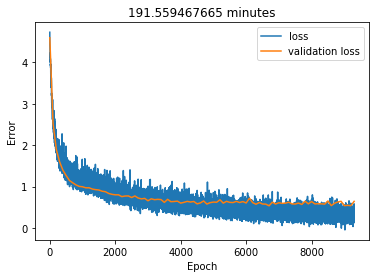

Starting epoch 	9301
Starting epoch 	9302
Starting epoch 	9303
Starting epoch 	9304
Starting epoch 	9305
Starting epoch 	9306
Starting epoch 	9307
Starting epoch 	9308
Starting epoch 	9309
Starting epoch 	9310
Starting epoch 	9311
Starting epoch 	9312
Starting epoch 	9313
Starting epoch 	9314
Starting epoch 	9315
Starting epoch 	9316
Starting epoch 	9317
Starting epoch 	9318
Starting epoch 	9319
Starting epoch 	9320
Starting epoch 	9321
Starting epoch 	9322
Starting epoch 	9323
Starting epoch 	9324
Starting epoch 	9325
Starting epoch 	9326
Starting epoch 	9327
Starting epoch 	9328
Starting epoch 	9329
Starting epoch 	9330
Starting epoch 	9331
Starting epoch 	9332
Starting epoch 	9333
Starting epoch 	9334
Starting epoch 	9335
Starting epoch 	9336
Starting epoch 	9337
Starting epoch 	9338
Starting epoch 	9339
Starting epoch 	9340
Starting epoch 	9341
Starting epoch 	9342
Starting epoch 	9343
Starting epoch 	9344
Starting epoch 	9345
Starting epoch 	9346
Starting epoch 	9347
Starting epoc

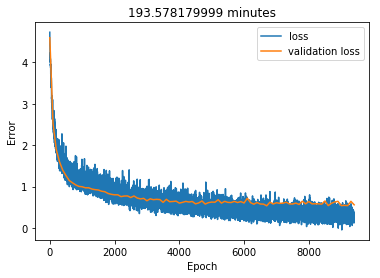

Starting epoch 	9401
Starting epoch 	9402
Starting epoch 	9403
Starting epoch 	9404
Starting epoch 	9405
Starting epoch 	9406
Starting epoch 	9407
Starting epoch 	9408
Starting epoch 	9409
Starting epoch 	9410
Starting epoch 	9411
Starting epoch 	9412
Starting epoch 	9413
Starting epoch 	9414
Starting epoch 	9415
Starting epoch 	9416
Starting epoch 	9417
Starting epoch 	9418
Starting epoch 	9419
Starting epoch 	9420
Starting epoch 	9421
Starting epoch 	9422
Starting epoch 	9423
Starting epoch 	9424
Starting epoch 	9425
Starting epoch 	9426
Starting epoch 	9427
Starting epoch 	9428
Starting epoch 	9429
Starting epoch 	9430
Starting epoch 	9431
Starting epoch 	9432
Starting epoch 	9433
Starting epoch 	9434
Starting epoch 	9435
Starting epoch 	9436
Starting epoch 	9437
Starting epoch 	9438
Starting epoch 	9439
Starting epoch 	9440
Starting epoch 	9441
Starting epoch 	9442
Starting epoch 	9443
Starting epoch 	9444
Starting epoch 	9445
Starting epoch 	9446
Starting epoch 	9447
Starting epoc

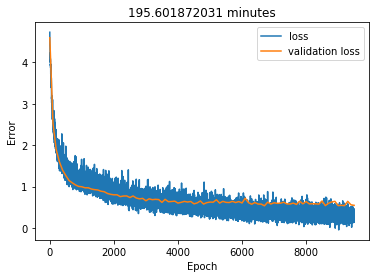

Starting epoch 	9501
Starting epoch 	9502
Starting epoch 	9503
Starting epoch 	9504
Starting epoch 	9505
Starting epoch 	9506
Starting epoch 	9507
Starting epoch 	9508
Starting epoch 	9509
Starting epoch 	9510
Starting epoch 	9511
Starting epoch 	9512
Starting epoch 	9513
Starting epoch 	9514
Starting epoch 	9515
Starting epoch 	9516
Starting epoch 	9517
Starting epoch 	9518
Starting epoch 	9519
Starting epoch 	9520
Starting epoch 	9521
Starting epoch 	9522
Starting epoch 	9523
Starting epoch 	9524
Starting epoch 	9525
Starting epoch 	9526
Starting epoch 	9527
Starting epoch 	9528
Starting epoch 	9529
Starting epoch 	9530
Starting epoch 	9531
Starting epoch 	9532
Starting epoch 	9533
Starting epoch 	9534
Starting epoch 	9535
Starting epoch 	9536
Starting epoch 	9537
Starting epoch 	9538
Starting epoch 	9539
Starting epoch 	9540
Starting epoch 	9541
Starting epoch 	9542
Starting epoch 	9543
Starting epoch 	9544
Starting epoch 	9545
Starting epoch 	9546
Starting epoch 	9547
Starting epoc

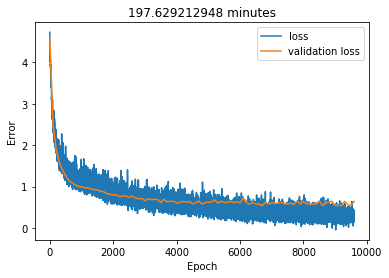

Starting epoch 	9601
Starting epoch 	9602
Starting epoch 	9603
Starting epoch 	9604
Starting epoch 	9605
Starting epoch 	9606
Starting epoch 	9607
Starting epoch 	9608
Starting epoch 	9609
Starting epoch 	9610
Starting epoch 	9611
Starting epoch 	9612
Starting epoch 	9613
Starting epoch 	9614
Starting epoch 	9615
Starting epoch 	9616
Starting epoch 	9617
Starting epoch 	9618
Starting epoch 	9619
Starting epoch 	9620
Starting epoch 	9621
Starting epoch 	9622
Starting epoch 	9623
Starting epoch 	9624
Starting epoch 	9625
Starting epoch 	9626
Starting epoch 	9627
Starting epoch 	9628
Starting epoch 	9629
Starting epoch 	9630
Starting epoch 	9631
Starting epoch 	9632
Starting epoch 	9633
Starting epoch 	9634
Starting epoch 	9635
Starting epoch 	9636
Starting epoch 	9637
Starting epoch 	9638
Starting epoch 	9639
Starting epoch 	9640
Starting epoch 	9641
Starting epoch 	9642
Starting epoch 	9643
Starting epoch 	9644
Starting epoch 	9645
Starting epoch 	9646
Starting epoch 	9647
Starting epoc

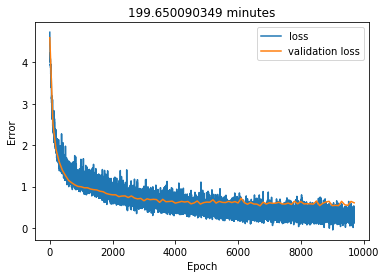

Starting epoch 	9701
Starting epoch 	9702
Starting epoch 	9703
Starting epoch 	9704
Starting epoch 	9705
Starting epoch 	9706
Starting epoch 	9707
Starting epoch 	9708
Starting epoch 	9709
Starting epoch 	9710
Starting epoch 	9711
Starting epoch 	9712
Starting epoch 	9713
Starting epoch 	9714
Starting epoch 	9715
Starting epoch 	9716
Starting epoch 	9717
Starting epoch 	9718
Starting epoch 	9719
Starting epoch 	9720
Starting epoch 	9721
Starting epoch 	9722
Starting epoch 	9723
Starting epoch 	9724
Starting epoch 	9725
Starting epoch 	9726
Starting epoch 	9727
Starting epoch 	9728
Starting epoch 	9729
Starting epoch 	9730
Starting epoch 	9731
Starting epoch 	9732
Starting epoch 	9733
Starting epoch 	9734
Starting epoch 	9735
Starting epoch 	9736
Starting epoch 	9737
Starting epoch 	9738
Starting epoch 	9739
Starting epoch 	9740
Starting epoch 	9741
Starting epoch 	9742
Starting epoch 	9743
Starting epoch 	9744
Starting epoch 	9745
Starting epoch 	9746
Starting epoch 	9747
Starting epoc

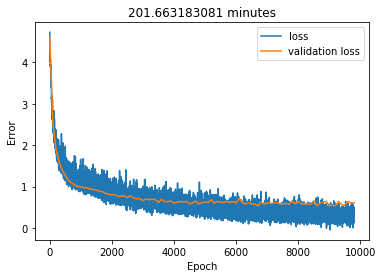

Starting epoch 	9801
Starting epoch 	9802
Starting epoch 	9803
Starting epoch 	9804
Starting epoch 	9805
Starting epoch 	9806
Starting epoch 	9807
Starting epoch 	9808
Starting epoch 	9809
Starting epoch 	9810
Starting epoch 	9811
Starting epoch 	9812
Starting epoch 	9813
Starting epoch 	9814
Starting epoch 	9815
Starting epoch 	9816
Starting epoch 	9817
Starting epoch 	9818
Starting epoch 	9819
Starting epoch 	9820
Starting epoch 	9821
Starting epoch 	9822
Starting epoch 	9823
Starting epoch 	9824
Starting epoch 	9825
Starting epoch 	9826
Starting epoch 	9827
Starting epoch 	9828
Starting epoch 	9829
Starting epoch 	9830
Starting epoch 	9831
Starting epoch 	9832
Starting epoch 	9833
Starting epoch 	9834
Starting epoch 	9835
Starting epoch 	9836
Starting epoch 	9837
Starting epoch 	9838
Starting epoch 	9839
Starting epoch 	9840
Starting epoch 	9841
Starting epoch 	9842
Starting epoch 	9843
Starting epoch 	9844
Starting epoch 	9845
Starting epoch 	9846
Starting epoch 	9847
Starting epoc

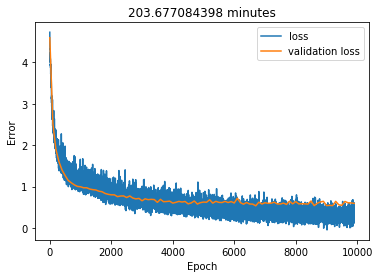

Starting epoch 	9901
Starting epoch 	9902
Starting epoch 	9903
Starting epoch 	9904
Starting epoch 	9905
Starting epoch 	9906
Starting epoch 	9907
Starting epoch 	9908
Starting epoch 	9909
Starting epoch 	9910
Starting epoch 	9911
Starting epoch 	9912
Starting epoch 	9913
Starting epoch 	9914
Starting epoch 	9915
Starting epoch 	9916
Starting epoch 	9917
Starting epoch 	9918
Starting epoch 	9919
Starting epoch 	9920
Starting epoch 	9921
Starting epoch 	9922
Starting epoch 	9923
Starting epoch 	9924
Starting epoch 	9925
Starting epoch 	9926
Starting epoch 	9927
Starting epoch 	9928
Starting epoch 	9929
Starting epoch 	9930
Starting epoch 	9931
Starting epoch 	9932
Starting epoch 	9933
Starting epoch 	9934
Starting epoch 	9935
Starting epoch 	9936
Starting epoch 	9937
Starting epoch 	9938
Starting epoch 	9939
Starting epoch 	9940
Starting epoch 	9941
Starting epoch 	9942
Starting epoch 	9943
Starting epoch 	9944
Starting epoch 	9945
Starting epoch 	9946
Starting epoch 	9947
Starting epoc

(array([4.73053694, 4.43526363, 4.38580275, ..., 0.28483525, 0.21616323,
        0.24864478]),
 array([4.59813261, 2.52161574, 1.89322114, 1.59651208, 1.3951081 ,
        1.26399446, 1.14596653, 1.09036088, 1.03919971, 1.00262046,
        0.99403232, 0.96913975, 0.97022671, 0.93851745, 0.92460835,
        0.91590607, 0.88640535, 0.87428468, 0.83228976, 0.81115049,
        0.79937071, 0.79944384, 0.75558913, 0.77024889, 0.77252162,
        0.73380429, 0.77204299, 0.72198129, 0.70090693, 0.71276313,
        0.65584737, 0.7025578 , 0.68241054, 0.69034702, 0.68449306,
        0.61661398, 0.69038296, 0.63303125, 0.63796109, 0.64658356,
        0.59916562, 0.61788625, 0.64051235, 0.62483728, 0.63893408,
        0.58069408, 0.60369968, 0.65042102, 0.5762319 , 0.60993427,
        0.62405336, 0.62073672, 0.6799078 , 0.59938663, 0.64148092,
        0.61694503, 0.61295968, 0.64129776, 0.61316228, 0.63590968,
        0.60270816, 0.71670026, 0.61045986, 0.57191044, 0.61342168,
        0.57737398, 0

In [9]:
# training parameters

training_params = {
    'epochs': 10000, 
    'val_step': 100, # at what intervals to do validation, divisible by NEPOCH
    'stoch_samples': 50, # how many stochastic dropout samples to use for a mean output reading 
    'minibatch': 25, # size of minibatches
    'train_x': dataX,
    'train_y': dataY,
    'val_x': dataX_val,
    'val_y': dataY_val,
}

forward_model.train_net(training_params)

In [ ]:
sess.run(tf.global_variables_initializer())

loss = np.zeros(NEPOCH)
val_loss = np.zeros(NEPOCH/val_step)

with tf.device('/cpu:0'):
    train_step = forward_model._net_ops['train']
    loss_op  = forward_model._net_ops['loss']
    bs = forward_model._params['batch_size']
    val_counter = 0
    counter = 0
    
    for i in range(NEPOCH): 
        if (i%25==0):
            print i
        b_start_counter = 0
        b_end_counter = bs
        
        feed_dict = {forward_model._net_ops['x']: dataX[b_start_counter:b_end_counter], forward_model._net_ops['y']: dataY[b_start_counter:b_end_counter]}
        feed_dict_val = {forward_model._net_ops['x']: dataX_val[0:bs], forward_model._net_ops['y']: dataY_val[0:bs]}
        
        for j in range(int(len(dataX))/bs):
            _, loss[i] = forward_model._sess.run([train_step, loss_op], feed_dict=feed_dict)
            
            b_start_counter += bs
            b_end_counter += bs
            #shift batch on
            feed_dict = {forward_model._net_ops['x']: dataX[b_start_counter:b_end_counter], forward_model._net_ops['y']: dataY[b_start_counter:b_end_counter]}
        
        if (i%val_step == 0):
            valSumSum = 0
            for j in range(int(len(dataX_val))):
                valSum = 0
                feed_dict_val = {forward_model._net_ops['x']: [dataX_val[j]], forward_model._net_ops['y']: [dataY_val[j]]}
                for l in range(stoch_samples):
                    valSum += forward_model._sess.run(loss_op, feed_dict=feed_dict_val)
                valSumSum += valSum/stoch_samples
            val_loss[val_counter] = valSumSum/len(dataX_val)
            val_counter += 1
            
        #reshuffle after epoch to avoid same cycle
        np.random.shuffle(train_data)
        dataX = train_data[:, np.r_[0, 1, 2, 3, 4, 5, 6, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]] # inputs
        dataY = train_data[:, [7,8, 9]] # end parameters
            
        np.random.shuffle(val_data)
        dataX_val = val_data[:, np.r_[0, 1, 2, 3, 4, 5, 6, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]] # inputs
        dataY_val = val_data[:, [7,8, 9]] # end parameters
        
        if (i%val_step == 0) and (i>1):
            #print loss[i]
            #print val_loss[i]
            plt.plot(range(0,i), loss[0:i], label = "loss")
            plt.plot(range(0,i+1,val_step), val_loss[0:val_counter], label = "validation loss")
            plt.show()
            
        counter +=1
        #print 'epoch: ',i+1, ', loss: ', round(loss[i], 3), ', last calculated val loss: ',round(val_loss[val_counter-1], 3), 'time elapsed: ',round((time.time()-t0)/60), 'minutes' 
        

In [ ]:
for n in range(4): 
    shape_id = shape_ids[n]
    probe_radius = 0.004745
    
    if (shape_id == 'ellip1' or shape_id == 'ellip2' or shape_id == 'ellip3' or shape_id == 'butter'):
        shape_polygon = shape_db.shape_db[shape_id]['shape'][0]
    else:
        shape_polygon = shape_db.shape_db[shape_id]['shape']
        shape_polygon.append(shape_polygon[0])
     
    # average over multiple stochastic models to get averaged
    feed_dict = {forward_model._net_ops['x']: dataX_vals[n]}
    
    with tf.device('/cpu:0'):
        ccpredictions_mus = []
    
        for i in range(stoch_samples*10):
            mus_op = forward_model._net_ops['mu']
            sigmas_op  = forward_model._net_ops['sigma']
            pis_op = forward_model._net_ops['pi']
    
            out_mus = forward_model._sess.run(mus_op, feed_dict=feed_dict)
            out_sigmas = forward_model._sess.run(sigmas_op, feed_dict=feed_dict)
            out_pis = forward_model._sess.run(pis_op, feed_dict=feed_dict)
    
            concat_out_pis = np.swapaxes(np.array([out_pis, out_pis, out_pis]),0,1) # make shape same as mus
            weighted_mus = out_mus*concat_out_pis
            ccpredictions_mus.append(np.sum(weighted_mus,2).tolist())
    
        sum_avg_err_NN = np.sum(np.mean(np.abs(dataY_vals[n]-np.mean(ccpredictions_mus, axis = 0)), axis = 0))
    
        # de_rescale 
        ccpredictions_mus = (ccpredictions_mus*(Ymaxs-Ymins))+Ymins
        dataX_val = (dataX_vals[n]*(Xmaxs-Xmins))+Xmins  
        dataY_val = (dataY_vals[n]*(Ymaxs-Ymins))+Ymins
        
        ccpredictions_mus_mean = np.mean(ccpredictions_mus, axis = 0)
        ccpredictions_sigmas = np.std(ccpredictions_mus, axis = 0)
        
        #better error measure
        dXYtheta = dataY_val-ccpredictions_mus_mean
        hypoten = []
        for e in range(len(dXYtheta)):
            dist = np.sqrt(np.square(dXYtheta[e][0])+np.square(dXYtheta[e][1]))
            hypoten.append(dist)
        DIST_avg_err_NN = np.mean(hypoten)
        DIST_std_err_NN = np.std(hypoten)
        ROTA_avg_err_NN = np.mean(np.abs(dXYtheta[:,2]))
        ROTA_std_err_NN = np.std(np.abs(dXYtheta[:,2]))
        
    print sum_avg_err_NN, '= sum_avg_err_NN for shape', shape_id
    print DIST_avg_err_NN, '= DIST_avg_err_NN for shape', shape_id
    print DIST_std_err_NN, '= DIST_std_err_NN for shape', shape_id
    print ROTA_avg_err_NN, '= ROTA_avg_err_NN for shape', shape_id
    print ROTA_std_err_NN, '= ROTA_std_err_NN for shape', shape_id
    
    dataX_test = dataX_val
    dataY_test = dataY_val
    counter = 0
    
    if (shape_id!='ellip1' and shape_id!='ellip2' and shape_id!='ellip3'):
        for i in range(len(dataX_test)):
            obj_start = dataX_test[i, [4, 5, 6]]
            transformed_start = rigidtransform(shape_polygon, obj_start)
            plottransformed_obj(transformed_start, 'g', 1.0)
            plottransformed_pusher(dataX_test[i,0], dataX_test[i,1], probe_radius, 'g')

            transformed_end = rigidtransform(shape_polygon, dataY_test[i])
            plottransformed_obj(transformed_end, 'r', 1.0)
            plottransformed_pusher(dataX_test[i,2], dataX_test[i,3], probe_radius, 'r')

            pred = ccpredictions_mus_mean[i] ## uncomment to use convex combination
            pred_sig = ccpredictions_sigmas[i]
            #pred = predictions[i]
    
            xs = np.linspace(pred[0]-pred_sig[0], pred[0]+pred_sig[0], 3)
            ys = np.linspace(pred[1]-pred_sig[1], pred[1]+pred_sig[1], 3)
            thetas = np.linspace(pred[2]-pred_sig[2], pred[2]+pred_sig[2], 3)
    
            for i in xs:
                for j in ys:
                    for l in thetas:
                        transformed_pred = rigidtransform(shape_polygon, [i,j,l])
                        plottransformed_obj(transformed_pred, 'b', 0.2)
                
            transformed_pred = rigidtransform(shape_polygon, pred)
            plottransformed_obj(transformed_pred, 'b', 1)
                
            print 'NN'
            plt.show()            
    else:
        for i in range(len(dataX_test)):
            obj_startX = dataX_test[i, [4]]
            obj_startY = dataX_test[i, [5]]
            obj_startTheta = dataX_test[i, [6]]
            obj_endX = dataY_test[i, [0]]
            obj_endY = dataY_test[i, [1]]
            obj_endTheta = dataY_test[i, [2]]
    
            pred = ccpredictions_mus_mean[i] ## uncomment to use convex combination
            pred_sig = ccpredictions_sigmas[i]
    
            plt.figure(figsize=(4, 4))
    
            plt.figure(i).add_subplot(111, aspect='equal').add_artist(Ellipse((obj_startX, obj_startY), shape_polygon[0]*2, shape_polygon[1]*2, angle=math.degrees(obj_startTheta), fill=False, color='g'))
            plottransformed_pusher(dataX_test[i,0], dataX_test[i,1], probe_radius, 'g')
            plt.figure(i).add_subplot(111, aspect='equal').add_artist(Ellipse((obj_endX, obj_endY), shape_polygon[0]*2, shape_polygon[1]*2, angle=math.degrees(obj_endTheta), fill=False, color='r'))
            plottransformed_pusher(dataX_test[i,2], dataX_test[i,3], probe_radius, 'r')
    
            xs = np.linspace(pred[0]-pred_sig[0], pred[0]+pred_sig[0], 3)
            ys = np.linspace(pred[1]-pred_sig[1], pred[1]+pred_sig[1], 3)
            thetas = np.linspace(pred[2]-pred_sig[2], pred[2]+pred_sig[2], 3)
    
            for m in xs:
                for j in ys:
                    for l in thetas:
                        plt.figure(i).add_subplot(111, aspect='equal').add_artist(Ellipse((m, j), shape_polygon[0]*2, shape_polygon[1]*2, angle=math.degrees(l), fill=False, color='b', alpha = 0.1))
                
            print 'NN'
            plt.figure(i).add_subplot(111, aspect='equal').add_artist(Ellipse((pred[0], pred[1]), shape_polygon[0]*2, shape_polygon[1]*2, angle=math.degrees(pred[2]), fill=False, color='b', alpha = 1))
            plt.axis([obj_startX-0.15, obj_startX+0.15, obj_startY-0.15, obj_startY+0.15])
            plt.show()        
        print counter
        counter +=1
    t1 = time.time()

    total = t1-t0
    print total/60 #time in minutes

In [ ]:
y_mean = np.mean(dataY_test, axis=0)
end_obs = dataY_test
end_pred = ccpredictions_mus_mean

pred_diff_squared = np.square(end_obs-end_pred)
obs_diff_squared = np.square(end_obs-y_mean)

n_summed_obs = np.sum(obs_diff_squared, axis=0)
n_summed_pred = np.sum(pred_diff_squared, axis=0)

nmse = n_summed_pred/n_summed_obs
print nmse
print np.sum(nmse)

In [ ]:
y_mean = np.mean(dataY_test, axis=0)

In [ ]:
width = 0.35

self_dists_samples =  [[0.0051222339288334263, 0.0044158771643205835, 0.0055815628117350888],[0.0055966727612206321, 0.0052129928893983784, 0.0053804816110431036],[0.0055966727612206321, 0.0052129928893983784, 0.0053804816110431036],[0.0062445242198103552, 0.0077418373545106618, 0.0061277925049182556]]
self_rots_samples =  [[0.11908324792858131, 0.11306688419043792, 0.13449593724190473],[0.13315670483678643, 0.15913810546391505, 0.16429507204279439],[0.13315670483678643, 0.15913810546391505, 0.16429507204279439],[0.16339293662301596, 0.20019611339372209, 0.1321339022201474]]
self_dists_std = (np.std(self_dists_samples, axis=1)*1000)/np.sqrt(40)
self_rots_std = np.std(self_rots_samples, axis=1)/np.sqrt(40)
self_dists = (np.mean(self_dists_samples, axis=1)*1000)
self_rots = np.mean(self_rots_samples, axis=1)

dists = np.array([0.00376513128265,0.00569862031285,0.00400732900878,0.00513413780176])*1000
rots = np.array([0.114779675876,0.1966752851,0.12398435151,0.162222983751])
dists_std = (np.array([0.00215905836733,0.00363459768816,0.00224951820607,0.00336522636219])*1000)/np.sqrt(400)
rots_std = (np.array([0.181019167684,0.358298909743,0.231339061904,0.228280870148]))/np.sqrt(400)
ind = np.arange(len(dists))
# distances x 1000 to scale it from m to mm
#fig, ax3 = plt.subplots(figsize=(10, 5))

fig, ax1 = plt.subplots(figsize=(10, 5))
fig, dudax = plt.subplots()
width = 0.2
bar1 = ax1.bar(ind-width-width, dists, width, color='b', yerr=dists_std, capsize=3, hatch="*")
bar2 = ax1.bar(ind-width, self_dists, width, color='b', yerr=self_dists_std, capsize=3)

ax1.set_xlabel('Shape')
ax1.set_title('')
ax1.set_xticks(ind + width/2 + width)
ax1.set_xticklabels(('rect1', 'ellip1', 'tri1', 'butter'))
ax1.set_ylabel('Avg Translation Error (mm)', color='b')
ax1.tick_params('y', colors='b')

dudbar1 = dudax.bar(ind, dists, width, color="1", hatch="*", edgecolor = "0")
dudbar2 = dudax.bar(ind, dists, width, color="1", edgecolor = "0")
ax1.legend((dudbar1[0], dudbar2[0]), ('Shape-generalized', 'Self-generalized'))

ax2 = ax1.twinx()
bar3 = ax2.bar(ind, rots, width, yerr=rots_std, capsize=3, color = 'r', hatch="*")
bar4 = ax2.bar(ind+width, self_rots, width, yerr=self_rots_std, capsize=3, color = 'r')
ax2.set_xticks(ind + width/2 - width)
rotationname = 'Avg Rotation Error (' + r'$\theta$)'
ax2.set_ylabel(rotationname, color='r')
ax2.tick_params('y', colors='r')
#ax2.set_ylim([0, 0.6])

fig.tight_layout()
plt.show()





































ax3.bar(ind-width, dists, width, yerr=dists_std, capsize=3, color='b')
ax3.set_xlabel('Shape')
# Make the y-axis label, ticks and tick labels match the line color.
ax3.set_ylabel('Avg Translation Error (mm)', color='b')
ax3.tick_params('y', colors='b')
ax3.set_xticks(ind-width/2)
ax3.set_xticklabels(('rect1', 'ellip1', 'tri1', 'butter'))

ax4 = ax3.twinx()
ax4.bar(ind, rots, width, yerr=rots_std, capsize=3, color = 'r')
rotationname = 'Avg Rotation Error (' + r'$\theta$)'
ax4.set_ylabel(rotationname, color='r')
ax4.tick_params('y', colors='r')
ax4.set_ylim([0, 0.6])

fig.tight_layout()
plt.show()

In [ ]:
shape_pred_dist_err_NN =  [[0.0051222339288334263, 0.0044158771643205835, 0.0055815628117350888],[0.0055966727612206321, 0.0052129928893983784, 0.0053804816110431036],[0.0055966727612206321, 0.0052129928893983784, 0.0053804816110431036],[0.0062445242198103552, 0.0077418373545106618, 0.0061277925049182556]]
shape_pred_rota_err_NN =  [[0.11908324792858131, 0.11306688419043792, 0.13449593724190473],[0.13315670483678643, 0.15913810546391505, 0.16429507204279439],[0.13315670483678643, 0.15913810546391505, 0.16429507204279439],[0.16339293662301596, 0.20019611339372209, 0.1321339022201474]]
shape_pred_dist_err_KDE_silvermann =  [[0.0076849848465869028, 0.0061239361354140827, 0.0066136406935347405],[0.007095955688400513, 0.0067535231127581379, 0.0070346329249749533],[0.007095955688400513, 0.0067535231127581379, 0.0070346329249749533],[0.0067218774124073203, 0.0071787339605984693, 0.0068800714419015047]]
shape_pred_rota_err_KDE_silvermann =  [[0.1628712066097272, 0.18399190153472958, 0.14635497744347506],[0.17927241083699877, 0.14591283781941025, 0.1874788206645388],[0.17927241083699877, 0.14591283781941025, 0.1874788206645388],[0.18773167922290554, 0.19606564396288928, 0.16156655221565774]]

butter
shape_pred_dist_err_NN =  []
shape_pred_rota_err_NN =  []
shape_pred_dist_err_KDE_silvermann =  [[
shape_pred_rota_err_KDE_silvermann =  []


In [ ]:
width = 0.35
dists = np.array([0.00376513128265,0.00569862031285,0.00400732900878,0.00513413780176])*1000
rots = np.array([0.114779675876,0.1966752851,0.12398435151,0.162222983751])
dists_std = (np.array([0.00215905836733,0.00363459768816,0.00224951820607,0.00336522636219])*1000)/np.sqrt(400)
rots_std = (np.array([0.181019167684,0.358298909743,0.231339061904,0.228280870148]))/np.sqrt(400)
ind = np.arange(len(dists))
# distances x 1000 to scale it from m to mm
#fig, ax3 = plt.subplots(figsize=(10, 5))
fig, ax3 = plt.subplots()

ax3.bar(ind-width, dists, width, yerr=dists_std, capsize=3, color='b')
ax3.set_xlabel('Shape')
# Make the y-axis label, ticks and tick labels match the line color.
ax3.set_ylabel('Avg Translation Error (mm)', color='b')
ax3.tick_params('y', colors='b')
ax3.set_xticks(ind-width/2)
ax3.set_xticklabels(('rect1', 'ellip1', 'tri1', 'butter'))

ax4 = ax3.twinx()
ax4.bar(ind, rots, width, yerr=rots_std, capsize=3, color = 'r')
rotationname = 'Avg Rotation Error (' + r'$\theta$)'
ax4.set_ylabel(rotationname, color='r')
ax4.tick_params('y', colors='r')
ax4.set_ylim([0, 0.6])

fig.tight_layout()
plt.show()

In [ ]:
# dist and rotation errors from shape gen results of rect1, ellip1, tri1, butter with mods 1,5,10,20,50,100,200,400
dists_avg = np.transpose([[0.004174072201,0.00539508588936,0.00406902624002,0.00561273291433],[0.00424745812569,0.0059672177021,0.0044816880945,0.00582550026999],[0.00371908713442,0.00511543824635,0.00371321917808,0.00491286851325],[0.00402253928778,0.00510835481356,0.00405491690961,0.00511058820482],[0.00364162855923,0.00483592603532,0.00363702164553,0.00523133984924],[0.00383869051779,0.00477036059801,0.004284059003,0.00489811435511],[0.00407818530496,0.00577834449012,0.00414091982503,0.00508186111089],[0.00376513128265,0.00569862031285,0.00400732900878,0.00513413780176]])*1000
dists_std = np.transpose([[0.00259115737967,0.00416847071369,0.0025910897571,0.004019517648],[0.00248442641551,0.00355023655479,0.00280208671003,0.00607067084104],[0.00222420980624,0.00332107492258,0.00250263294026,0.00306031644755],[0.00321723098336,0.00377211435231,0.00248781832546,0.00373984746373],[0.00212480873796,0.00346466418531,0.00207069510347,0.00550469333458],[0.00230905423479,0.00300393992134,0.00242575958624,0.00327214707882],[0.00249478325989,0.00338054593903,0.00260663151293,0.00348589586966],[0.00215905836733,0.00363459768816,0.00224951820607,0.00336522636219]])*1000/np.sqrt(350)
rot_avg = np.transpose([[0.252274843628,0.366062875924,0.264648902447,0.390669092195],[0.121372220378,0.195967766555,0.133392494195,0.167594886496],[0.107112309389,0.192605699812,0.123241465214,0.147309826954],[0.125262553663,0.208092778887,0.148133068346,0.182191689339],[0.114813439128,0.195663087689,0.117820021479,0.150275371795],[0.109302035738,0.180553580156,0.106860850896,0.139552317543],[0.123026070942,0.202021760767,0.124767310681,0.164774265556],[0.114779675876,0.1966752851,0.12398435151,0.162222983751]])
rot_std = np.transpose([[0.90067701073,1.13597599466,0.969728610913,1.18679226056],[0.176088307103,0.368047900846,0.265838159459,0.268763659631],[0.156569416959,0.383231924843,0.232517310955,0.22299063132],[0.186312993554,0.357767015242,0.227646049125,0.241558193308],[0.202555995106,0.448384368264,0.249450561399,0.262237078417],[0.160691750962,0.33472618728,0.186005455388,0.191406685614],[0.239778402977,0.432832441615,0.227494917001,0.305563147895],[0.181019167684,0.358298909743,0.231339061904,0.228280870148]])/np.sqrt(350)


In [ ]:
# dist and rotation errors from shape gen results of rect1, ellip1, tri1, butter with mods 1,5,10,20,50,100,200,400
dists_avg = np.transpose([[0.004174072201,0.00539508588936,0.00406902624002,0.00561273291433],[0.00424745812569,0.0059672177021,0.0044816880945,0.00582550026999],[0.00371908713442,0.00511543824635,0.00371321917808,0.00491286851325],[0.00402253928778,0.00510835481356,0.00405491690961,0.00511058820482],[0.00364162855923,0.00483592603532,0.00363702164553,0.00523133984924],[0.00383869051779,0.00477036059801,0.004284059003,0.00489811435511],[0.00407818530496,0.00577834449012,0.00414091982503,0.00508186111089],[0.00376513128265,0.00569862031285,0.00400732900878,0.00513413780176]])*1000
dists_std = np.transpose([[0.00259115737967,0.00416847071369,0.0025910897571,0.004019517648],[0.00248442641551,0.00355023655479,0.00280208671003,0.00607067084104],[0.00222420980624,0.00332107492258,0.00250263294026,0.00306031644755],[0.00321723098336,0.00377211435231,0.00248781832546,0.00373984746373],[0.00212480873796,0.00346466418531,0.00207069510347,0.00550469333458],[0.00230905423479,0.00300393992134,0.00242575958624,0.00327214707882],[0.00249478325989,0.00338054593903,0.00260663151293,0.00348589586966],[0.00215905836733,0.00363459768816,0.00224951820607,0.00336522636219]])*1000/np.sqrt(350)
rot_avg = np.transpose([[0.252274843628,0.366062875924,0.264648902447,0.390669092195],[0.121372220378,0.195967766555,0.133392494195,0.167594886496],[0.107112309389,0.192605699812,0.123241465214,0.147309826954],[0.125262553663,0.208092778887,0.148133068346,0.182191689339],[0.114813439128,0.195663087689,0.117820021479,0.150275371795],[0.109302035738,0.180553580156,0.106860850896,0.139552317543],[0.123026070942,0.202021760767,0.124767310681,0.164774265556],[0.114779675876,0.1966752851,0.12398435151,0.162222983751]])
rot_std = np.transpose([[0.90067701073,1.13597599466,0.969728610913,1.18679226056],[0.176088307103,0.368047900846,0.265838159459,0.268763659631],[0.156569416959,0.383231924843,0.232517310955,0.22299063132],[0.186312993554,0.357767015242,0.227646049125,0.241558193308],[0.202555995106,0.448384368264,0.249450561399,0.262237078417],[0.160691750962,0.33472618728,0.186005455388,0.191406685614],[0.239778402977,0.432832441615,0.227494917001,0.305563147895],[0.181019167684,0.358298909743,0.231339061904,0.228280870148]])/np.sqrt(350)

m = [1,5,10,20,50,100,200,400]

plt.figure()
plt.errorbar(m, dists_avg[0], yerr=dists_std[0], marker='s', color='b')
plt.errorbar(m, dists_avg[1], yerr=dists_std[1], marker='o', color='r')
plt.errorbar(m, dists_avg[2], yerr=dists_std[2], marker='^', color='g')
plt.errorbar(m, dists_avg[3], yerr=dists_std[3], marker='x', color='c')
plt.show()

plt.figure()
plt.errorbar(m, rot_avg[0], yerr=rot_std[0], marker='s', color='b')
plt.errorbar(m, rot_avg[1], yerr=rot_std[1], marker='o', color='r')
plt.errorbar(m, rot_avg[2], yerr=rot_std[2], marker='^', color='g')
plt.errorbar(m, rot_avg[3], yerr=rot_std[3], marker='x', color='c')
plt.show()

In [ ]:
# dist and rotation errors from shape gen results of rect1, ellip1, tri1, butter with mods 1,5,10,20,50,100,200,400
dists_avg = np.transpose([[0.004174072201,0.00539508588936,0.00406902624002,0.00561273291433],[0.00424745812569,0.0059672177021,0.0044816880945,0.00582550026999],[0.00371908713442,0.00511543824635,0.00371321917808,0.00491286851325],[0.00402253928778,0.00510835481356,0.00405491690961,0.00511058820482],[0.00364162855923,0.00483592603532,0.00363702164553,0.00523133984924],[0.00383869051779,0.00477036059801,0.004284059003,0.00489811435511]])*1000
dists_std = np.transpose([[0.00259115737967,0.00416847071369,0.0025910897571,0.004019517648],[0.00248442641551,0.00355023655479,0.00280208671003,0.00607067084104],[0.00222420980624,0.00332107492258,0.00250263294026,0.00306031644755],[0.00321723098336,0.00377211435231,0.00248781832546,0.00373984746373],[0.00212480873796,0.00346466418531,0.00207069510347,0.00550469333458],[0.00230905423479,0.00300393992134,0.00242575958624,0.00327214707882]])*1000/np.sqrt(350)
rot_avg = np.transpose([[0.252274843628,0.366062875924,0.264648902447,0.390669092195],[0.121372220378,0.195967766555,0.133392494195,0.167594886496],[0.107112309389,0.192605699812,0.123241465214,0.147309826954],[0.125262553663,0.208092778887,0.148133068346,0.182191689339],[0.114813439128,0.195663087689,0.117820021479,0.150275371795],[0.109302035738,0.180553580156,0.106860850896,0.139552317543]])
rot_std = np.transpose([[0.90067701073,1.13597599466,0.969728610913,1.18679226056],[0.176088307103,0.368047900846,0.265838159459,0.268763659631],[0.156569416959,0.383231924843,0.232517310955,0.22299063132],[0.186312993554,0.357767015242,0.227646049125,0.241558193308],[0.202555995106,0.448384368264,0.249450561399,0.262237078417],[0.160691750962,0.33472618728,0.186005455388,0.191406685614]])/np.sqrt(350)

m = [1,5,10,20,50,100]
fig, ax = plt.subplots(figsize=(3, 3.5))
rect1 = ax.errorbar(m, dists_avg[0], yerr=dists_std[0], marker='s', color='b', capsize=3)
ellip1 = ax.errorbar(m, dists_avg[1], yerr=dists_std[1], marker='o', color='r', capsize=3)
tri1 = ax.errorbar(m, dists_avg[2], yerr=dists_std[2], marker='^', color='g', capsize=3)
butter = ax.errorbar(m, dists_avg[3], yerr=dists_std[3], marker='x', color='c', capsize=3)
ax.set_ylabel('Avg Translation Error (mm)')
ax.set_xlabel('Number of Kernels')
#ax.legend((rect1[0], ellip1[0], tri1[0], butter[0]), ('rect1', 'ellip1', 'tri1', 'butter'))
plt.show()

fig, ax2 = plt.subplots(figsize=(3, 3.5))
rect1 = ax2.errorbar(m, rot_avg[0], yerr=rot_std[0], marker='s', color='b', capsize=3)
ellip1 = ax2.errorbar(m, rot_avg[1], yerr=rot_std[1], marker='o', color='r', capsize=3)
tri1 = ax2.errorbar(m, rot_avg[2], yerr=rot_std[2], marker='^', color='g', capsize=3)
butter = ax2.errorbar(m, rot_avg[3], yerr=rot_std[3], marker='x', color='c', capsize=3)
rotationname = 'Avg Rotation Error (' + r'$\theta$)'
ax2.set_xlabel('Number of Kernels')
ax2.set_ylabel(rotationname)
ax2.legend((rect1[0], ellip1[0], tri1[0], butter[0]), ('rect1', 'ellip1', 'tri1', 'butter'))
plt.show()